### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sn
import tensorflow as tf
import tensorflow_addons as tfa

from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from leven import levenshtein

import glob
import sys
import os
import math
import gc
import sys
import sklearn
import time
import json

# TQDM Progress Bar With Pandas Apply Function
tqdm.pandas()

print(f'Tensorflow Version {tf.__version__}')
print(f'Python Version: {sys.version}')

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

Tensorflow Version 2.12.0
Python Version: 3.10.10 | packaged by conda-forge | (main, Mar 24 2023, 20:08:06) [GCC 11.3.0]


# Character 2 Ordinal Encoding

In [2]:
# Read Character to Ordinal Encoding Mapping
with open('/kaggle/input/asl-fingerspelling/character_to_prediction_index.json') as json_file:
    CHAR2ORD = json.load(json_file)
    
# Ordinal to Character Mapping
ORD2CHAR = {j:i for i,j in CHAR2ORD.items()}
    
# Character to Ordinal Encoding Mapping   
display(pd.Series(CHAR2ORD).to_frame('Ordinal Encoding'))

,Ordinal Encoding
,0
!,1
#,2
$,3
%,4
&,5
',6
(,7
),8
*,9


# Global Config

Hyperparameters
We define the hyperparameters that will be used later:

IS_INTERACTIVE: This variable indicates whether the notebook is running in interactive mode, which means it is being executed in an environment where changes and experiments can be performed interactively. In this mode, you can run code cells individually, modify the code, and see the results immediately. This is useful when developing and debugging code as it allows you to make quick changes and observe their effects in real-time. If you want to execute the complete code (5 hours), run it without interactive mode (save version or submit).

SEED: This is a global random seed used to reproduce the results. By setting a seed, it ensures that the results are consistent across different runs.

N_TARGET_FRAMES: This variable indicates the number of frames to which the recordings will be resized. This is done to standardize the length of input sequences.

DEBUG: This variable indicates whether it is running in debug mode. If True, it will run in debug mode, which may involve running a subset of the data for faster execution and easier debugging.

N_UNIQUE_CHARACTERS0: This variable represents the number of unique characters that the model should predict. It does not include the padding token, the start of sentence token, and the end of sentence token.

N_UNIQUE_CHARACTERS: This variable is similar to N_UNIQUE_CHARACTERS0, but includes the padding token, the start of sentence token, and the end of sentence token. Therefore, it represents the total number of classes the model should predict.

PAD_TOKEN, START_TOKEN, and END_TOKEN: These variables represent the indices of the padding, start of sentence, and end of sentence tokens in the vocabulary. They are used during data processing and target text sequence generation.

USE_VAL: This variable controls whether to use 10% of the data for validation during training.

BATCH_SIZE: This variable determines the batch size for training.

N_EPOCHS: This variable sets the number of epochs for training the model. If IS_INTERACTIVE is True, it is set to 2 for quick interactive training; otherwise, it is set to 100 for normal training.

N_WARMUP_EPOCHS: This variable defines the number of warm-up epochs in the learning rate scheduler.

LR_MAX: This variable sets the maximum learning rate for the training process.

WD_RATIO: This variable represents the weight decay ratio based on the learning rate.

MAX_PHRASE_LENGTH: This variable defines the maximum length of a phrase, including the end of sentence token.

TRAIN_MODEL: This variable controls whether to train the model.

LOAD_WEIGHTS: This variable controls whether to load pre-trained weights for the model.

WARMUP_METHOD: This variable specifies the warm-up method for the learning rate scheduler, either 'log' or 'exp'. If 'log', the learning rate gradually increases in a logarithmic manner during the initial warm-up epochs. This means that it increases slowly at first and then accelerates as the warm-up epochs progress. It is useful when a smoother and more gradual warm-up is desired. If 'exp', the learning rate increases exponentially during the initial warm-up epochs. This implies a faster increase at the beginning and a higher learning rate in the initial epochs. It is useful when a faster and more aggressive warm-up is desired.

In [3]:
# If Notebook Is Run By Committing or In Interactive Mode For Development
IS_INTERACTIVE = os.environ['KAGGLE_KERNEL_RUN_TYPE'] == 'Interactive'
# Verbose Setting during training
VERBOSE = 1 if IS_INTERACTIVE else 2
# Global Random Seed
SEED = 42
# Number of Frames to resize recording to
N_TARGET_FRAMES = 128
# Global debug flag, takes subset of train
DEBUG = False
# Number of Unique Characters To Predict + Pad Token + SOS Token + EOS Token
N_UNIQUE_CHARACTERS0 = len(CHAR2ORD)
N_UNIQUE_CHARACTERS = len(CHAR2ORD) + 1 + 1 + 1
PAD_TOKEN = len(CHAR2ORD) # Padding
SOS_TOKEN = len(CHAR2ORD) + 1 # Start Of Sentence
EOS_TOKEN = len(CHAR2ORD) + 2 # End Of Sentence
# Whether to use 10% of data for validation
USE_VAL = False
# Batch Size
BATCH_SIZE = 64
# Number of Epochs to Train for
N_EPOCHS = 2 if IS_INTERACTIVE else 100
# Number of Warmup Epochs in Learning Rate Scheduler
N_WARMUP_EPOCHS = 10
# Maximum Learning Rate
LR_MAX = 1e-3
# Weight Decay Ratio as Ratio of Learning Rate
WD_RATIO = 0.05
# Length of Phrase + EOS Token
MAX_PHRASE_LENGTH = 31 + 1
# Whether to Train The model
TRAIN_MODEL = False
# Whether to Load Pretrained Weights
LOAD_WEIGHTS = True
# Learning Rate Warmup Method [log,exp]
WARMUP_METHOD = 'exp'

# Plot Config

In [4]:
# MatplotLib Global Settings
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['axes.titlesize'] = 24

# Train

In [5]:
# Read Train DataFrame
if DEBUG:
    train = pd.read_csv('/kaggle/input/asl-fingerspelling/train.csv').head(5000)
else:
    train = pd.read_csv('/kaggle/input/asl-fingerspelling/train.csv')
    
# Set Train Indexed By sqeuence_id
train_sequence_id = train.set_index('sequence_id')

# Number Of Train Samples
N_SAMPLES = len(train)
print(f'N_SAMPLES: {N_SAMPLES}')

display(train.info())
display(train.head())

N_SAMPLES: 67208
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67208 entries, 0 to 67207
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   path            67208 non-null  object
 1   file_id         67208 non-null  int64 
 2   sequence_id     67208 non-null  int64 
 3   participant_id  67208 non-null  int64 
 4   phrase          67208 non-null  object
dtypes: int64(3), object(2)
memory usage: 2.6+ MB


None

,path,file_id,sequence_id,participant_id,phrase
0,train_landmarks/5414471.parquet,5414471,1816796431,217,3 creekhouse
1,train_landmarks/5414471.parquet,5414471,1816825349,107,scales/kuhaylah
2,train_landmarks/5414471.parquet,5414471,1816909464,1,1383 william lanier
3,train_landmarks/5414471.parquet,5414471,1816967051,63,988 franklin lane
4,train_landmarks/5414471.parquet,5414471,1817123330,89,6920 northeast 661st road


# File Path

In [6]:
# Get complete file path to file
def get_file_path(path):
    return f'/kaggle/input/asl-fingerspelling/{path}'

train['file_path'] = train['path'].apply(get_file_path)

# Example File Paths

In [7]:
# Unique Parquet Files
INFERENCE_FILE_PATHS = pd.Series(
        glob.glob('/kaggle/input/aslfr-preprocessing-dataset/train_landmark_subsets/*')
    )

print(f'Found {len(INFERENCE_FILE_PATHS)} Inference Pickle Files')

Found 10 Inference Pickle Files


# Load X/y

We load the training and validation files. In our case, USE_VAL=False, so we load the complete X and y. The original shape of the y files is [61955, 128], due to the padding we have applied. Since we have chosen the phrase limit to be 31+1 spaces, with the last space as the end-of-sentence token, we restrict the size from 128 to 32.

In [8]:
# Train/Validation
if USE_VAL:
    # TRAIN
    X_train = np.load('/kaggle/input/aslfr-preprocessing-dataset/X_train.npy')
    y_train = np.load('/kaggle/input/aslfr-preprocessing-dataset/y_train.npy')[:,:MAX_PHRASE_LENGTH]
    N_TRAIN_SAMPLES = len(X_train)
    # VAL
    X_val = np.load('/kaggle/input/aslfr-preprocessing-dataset/X_val.npy')
    y_val = np.load('/kaggle/input/aslfr-preprocessing-dataset/y_val.npy')[:,:MAX_PHRASE_LENGTH]
    N_VAL_SAMPLES = len(X_val)
    # Shapes
    print(f'X_train shape: {X_train.shape}, X_val shape: {X_val.shape}')
# Train On All Data
else:
    # TRAIN
    X_train = np.load('/kaggle/input/aslfr-preprocessing-dataset/X.npy')
    y_train = np.load('/kaggle/input/aslfr-preprocessing-dataset/y.npy')[:,:MAX_PHRASE_LENGTH]
    N_TRAIN_SAMPLES = len(X_train)
    print(f'X_train shape: {X_train.shape}')

X_train shape: (61955, 128, 164)


# Example Batch

We create batches of examples to debug or test the code. We create two sets of examples: one with a larger sample size (N_EXAMPLE_BATCH_SAMPLES) and another with a smaller sample size (N_EXAMPLE_BATCH_SAMPLES_SMALL).

In each set of examples, we create a dictionary X_batch containing the input features, and an array y_batch containing the output labels.

In the X_batch dictionary, we copy the first N_EXAMPLE_BATCH_SAMPLES training samples from X_train. The frames represent the data of the frames (rows in this case, where each row is a set of [1, 128, 164]), and phrase represents the phrases associated with the frames.

In the y_batch array, we copy the first N_EXAMPLE_BATCH_SAMPLES training labels from y_train, which correspond to the phrases associated with the frames.

We perform the same procedure for the smaller set, using the variables X_batch_small and y_batch_small.

In [9]:
# Example Batch For Debugging
N_EXAMPLE_BATCH_SAMPLES = 1024
N_EXAMPLE_BATCH_SAMPLES_SMALL = 32
# Example Batch
X_batch = {
    'frames': np.copy(X_train[:N_EXAMPLE_BATCH_SAMPLES]),
    'phrase': np.copy(y_train[:N_EXAMPLE_BATCH_SAMPLES]),
#     'phrase_type': np.copy(y_phrase_type_train[:N_EXAMPLE_BATCH_SAMPLES]),
}
y_batch = np.copy(y_train[:N_EXAMPLE_BATCH_SAMPLES])
# Small Example Batch
X_batch_small = {
    'frames': np.copy(X_train[:N_EXAMPLE_BATCH_SAMPLES_SMALL]),
    'phrase': np.copy(y_train[:N_EXAMPLE_BATCH_SAMPLES_SMALL]),
#     'phrase_type': np.copy(y_phrase_type_train[:N_EXAMPLE_BATCH_SAMPLES_SMALL]),
}
y_batch_small = np.copy(y_train[:N_EXAMPLE_BATCH_SAMPLES_SMALL])

# Example Parquet

In [10]:
# Read First Parquet File
# example_parquet_df = pd.read_parquet(train['file_path'][0])
example_parquet_df = pd.read_parquet(INFERENCE_FILE_PATHS[0])

# Each parquet file contains 1000 recordings
print(f'# Unique Recording: {example_parquet_df.index.nunique()}')
# Display DataFrame layout
display(example_parquet_df.head())

# Unique Recording: 1000


,x_left_hand_0,x_left_hand_1,x_left_hand_2,x_left_hand_3,x_left_hand_4,x_left_hand_5,x_left_hand_6,x_left_hand_7,x_left_hand_8,x_left_hand_9,...,y_face_314,y_face_317,y_face_318,y_face_321,y_face_324,y_face_375,y_face_402,y_face_405,y_face_409,y_face_415
sequence_id,,,,,,,,,,,,,,,,,,,,,
1816796431,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.551424,0.538415,0.539000,0.546458,0.539715,0.543958,0.538425,0.549351,0.538230,0.540015
1816796431,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.550706,0.538216,0.538723,0.545990,0.539296,0.543357,0.538225,0.548827,0.537376,0.539256
1816796431,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.550613,0.537836,0.538564,0.545949,0.539212,0.543279,0.537961,0.548796,0.537360,0.539332
1816796431,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.549740,0.536994,0.538449,0.545622,0.539666,0.543694,0.537328,0.548015,0.538301,0.539954
1816796431,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.550614,0.538677,0.540376,0.547104,0.541524,0.545222,0.539203,0.549211,0.539734,0.541707


# Landmark Indices

In [11]:
# Get indices in original dataframe
def get_idxs(df, words_pos, words_neg=[], ret_names=True, idxs_pos=None):
    idxs = []
    names = []
    for w in words_pos:
        for col_idx, col in enumerate(example_parquet_df.columns):
            # Exclude Non Landmark Columns
            if col in ['frame']:
                continue
                
            col_idx = int(col.split('_')[-1])
            # Check if column name contains all words
            if (w in col) and (idxs_pos is None or col_idx in idxs_pos) and all([w not in col for w in words_neg]):
                idxs.append(col_idx)
                names.append(col)
    # Convert to Numpy arrays
    idxs = np.array(idxs)
    names = np.array(names)
    # Returns either both column indices and names
    if ret_names:
        return idxs, names
    # Or only columns indices
    else:
        return idxs

In [12]:
# Lips Landmark Face Ids
LIPS_LANDMARK_IDXS = np.array([
        61, 185, 40, 39, 37, 0, 267, 269, 270, 409,
        291, 146, 91, 181, 84, 17, 314, 405, 321, 375,
        78, 191, 80, 81, 82, 13, 312, 311, 310, 415,
        95, 88, 178, 87, 14, 317, 402, 318, 324, 308,
    ])

# Landmark Indices for Left/Right hand without z axis in raw data
LEFT_HAND_IDXS0, LEFT_HAND_NAMES0 = get_idxs(example_parquet_df, ['left_hand'], ['z'])
RIGHT_HAND_IDXS0, RIGHT_HAND_NAMES0 = get_idxs(example_parquet_df, ['right_hand'], ['z'])
LIPS_IDXS0, LIPS_NAMES0 = get_idxs(example_parquet_df, ['face'], ['z'], idxs_pos=LIPS_LANDMARK_IDXS)
COLUMNS0 = np.concatenate((LEFT_HAND_NAMES0, RIGHT_HAND_NAMES0, LIPS_NAMES0))
N_COLS0 = len(COLUMNS0)
# Only X/Y axes are used
N_DIMS0 = 2

print(f'N_COLS0: {N_COLS0}')

N_COLS0: 164


In [13]:
# Landmark Indices in subset of dataframe with only COLUMNS selected
LEFT_HAND_IDXS = np.argwhere(np.isin(COLUMNS0, LEFT_HAND_NAMES0)).squeeze()
RIGHT_HAND_IDXS = np.argwhere(np.isin(COLUMNS0, RIGHT_HAND_NAMES0)).squeeze()
LIPS_IDXS = np.argwhere(np.isin(COLUMNS0, LIPS_NAMES0)).squeeze()
HAND_IDXS = np.concatenate((LEFT_HAND_IDXS, RIGHT_HAND_IDXS), axis=0)
N_COLS = N_COLS0
# Only X/Y axes are used
N_DIMS = 2

print(f'N_COLS: {N_COLS}')

N_COLS: 164


In [14]:
# Indices in processed data by axes with only dominant hand
HAND_X_IDXS = np.array(
        [idx for idx, name in enumerate(LEFT_HAND_NAMES0) if 'x' in name]
    ).squeeze()
HAND_Y_IDXS = np.array(
        [idx for idx, name in enumerate(LEFT_HAND_NAMES0) if 'y' in name]
    ).squeeze()
# Names in processed data by axes
HAND_X_NAMES = LEFT_HAND_NAMES0[HAND_X_IDXS]
HAND_Y_NAMES = LEFT_HAND_NAMES0[HAND_Y_IDXS]

# Mean/STD Loading

In [15]:
# Mean/Standard Deviations of data used for normalizing
MEANS = np.load('/kaggle/input/aslfr-preprocessing-dataset/MEANS.npy').reshape(-1)
STDS = np.load('/kaggle/input/aslfr-preprocessing-dataset/STDS.npy').reshape(-1)

# Tensorflow Preprocessing Layer

In [16]:
"""
    Tensorflow layer to process data in TFLite
    Data needs to be processed in the model itself, so we can not use Python
""" 
class PreprocessLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(PreprocessLayer, self).__init__()
        self.normalisation_correction = tf.constant(
                    # Add 0.50 to x coordinates of left hand (original right hand) and substract 0.50 of right hand (original left hand)
                     [0.50 if 'x' in name else 0.00 for name in LEFT_HAND_NAMES0],
                dtype=tf.float32,
            )
    
    @tf.function(
        input_signature=(tf.TensorSpec(shape=[None,N_COLS0], dtype=tf.float32),),
    )
    def call(self, data0, resize=True):
        # Fill NaN Values With 0
        data = tf.where(tf.math.is_nan(data0), 0.0, data0)
        
        # Hacky
        data = data[None]
        
        # Empty Hand Frame Filtering
        hands = tf.slice(data, [0,0,0], [-1, -1, 84])
        hands = tf.abs(hands)
        mask = tf.reduce_sum(hands, axis=2)
        mask = tf.not_equal(mask, 0)
        data = data[mask][None]
        
        # Pad Zeros
        N_FRAMES = len(data[0])
        if N_FRAMES < N_TARGET_FRAMES:
            data = tf.concat((
                data,
                tf.zeros([1,N_TARGET_FRAMES-N_FRAMES,N_COLS], dtype=tf.float32)
            ), axis=1)
        # Downsample
        data = tf.image.resize(
            data,
            [1, N_TARGET_FRAMES],
            method=tf.image.ResizeMethod.BILINEAR,
        )
        
        # Squeeze Batch Dimension
        data = tf.squeeze(data, axis=[0])
        
        return data
    
preprocess_layer = PreprocessLayer()

In [17]:
# Function To Test Preprocessing Layer
def test_preprocess_layer():
    demo_sequence_id = example_parquet_df.index.unique()[15]
    demo_raw_data = example_parquet_df.loc[demo_sequence_id, COLUMNS0]
    data = preprocess_layer(demo_raw_data)

    print(f'demo_raw_data shape: {demo_raw_data.shape}')
    print(f'data shape: {data.shape}')
    
    return data
    
if IS_INTERACTIVE:
    data = test_preprocess_layer()

# Train Dataset

We proceed to create the training dataset through the function get_train_dataset, which takes the variables X, y, and the batch size as arguments.

Inside the function, an array called sample_idxs is created, containing the indices of the samples in the dataset.

Then, an infinite loop is created using the while True statement, allowing continuous iteration over the dataset in batches.

In each iteration, random indices are obtained from sample_idxs using the np.random.choice function. batch_size random indices are selected without replacement.

Next, two dictionaries are created: inputs and outputs. In inputs, the batches of frames and phrases corresponding to the selected random indices are assigned. In outputs, the batch of y corresponding to the random indices is assigned.

Finally, the yield statement is used to return the dictionaries inputs and outputs as a pair of values in each iteration of the generator.

This way, when calling the function get_train_dataset, a generator is obtained that can be used in a for loop to iterate over the training batches in each training epoch. Each batch contains the input and output data corresponding to the selected random indices.

In the context of model training, the data generator is used to efficiently provide training samples batches during the training process.

The data generator is used as the x value in the fit() method of the model. Instead of passing all the training data directly as a large tensor, which could occupy a lot of memory and be inefficient, a data generator is used to provide smaller batches of samples at each training step.

The get_train_dataset function returns an infinite generator that, in each iteration, takes a random batch of training samples (batch_size) from the training dataset X and y. Each batch of samples is a dictionary with two keys: 'frames' and 'phrase'. The input data is in the 'frames' key, containing sequences of numerical data corresponding to the "frames" (input data sequences). The output data (labels) is in the 'phrase' key, containing sequences of integer indices representing the "phrases" (desired output sequences).

When the model's fit() method receives this data generator (train_dataset) as x, it runs in each training epoch and takes batches of samples from the generator to update the model's weights. This allows training the model using all the training data but without loading them all into memory at the same time, which is useful for large datasets. The generator will continue providing batches of samples indefinitely during training, ensuring that the model is trained on all available training samples.

In [18]:
# Train Dataset Iterator
def get_train_dataset(X, y, batch_size=BATCH_SIZE):
    sample_idxs = np.arange(len(X))
    while True:
        # Get random indices
        random_sample_idxs = np.random.choice(sample_idxs, batch_size)
        
        inputs = {
            'frames': X[random_sample_idxs],
            'phrase': y[random_sample_idxs],
        }
        outputs = y[random_sample_idxs]
        
        yield inputs, outputs

In [19]:
# Train Dataset
train_dataset = get_train_dataset(X_train, y_train)

In [20]:
# Training Steps Per Epoch
TRAIN_STEPS_PER_EPOCH = math.ceil(N_TRAIN_SAMPLES / BATCH_SIZE)
print(f'TRAIN_STEPS_PER_EPOCH: {TRAIN_STEPS_PER_EPOCH}')

TRAIN_STEPS_PER_EPOCH: 969


# Validation Dataset

In [21]:
# Validation Set
def get_val_dataset(X, y, batch_size=BATCH_SIZE):
    offsets = np.arange(0, len(X), batch_size)
    while True:
        # Iterate over whole validation set
        for offset in offsets:
            inputs = {
                'frames': X[offset:offset+batch_size],
                'phrase': y[offset:offset+batch_size],
            }
            outputs = y[offset:offset+batch_size]

            yield inputs, outputs

In [22]:
# Validation Dataset
if USE_VAL:
    val_dataset = get_val_dataset(X_val, y_val)

In [23]:
if USE_VAL:
    N_VAL_STEPS_PER_EPOCH = math.ceil(N_VAL_SAMPLES / BATCH_SIZE)
    print(f'N_VAL_STEPS_PER_EPOCH: {N_VAL_STEPS_PER_EPOCH}')

# Model Config

Prior to the modeling process, we will explain what a Transformer model consists of:

Unlike traditional recurrent architectures such as Recurrent Neural Networks (RNN) or Convolutional Neural Networks (CNN), which rely on recurrent connections or convolutions to capture temporal dependencies in sequential data, the Transformer model is based on attention mechanisms to capture these dependencies. The main focus of the attention mechanism is to calculate relationships between all elements of a sequence, assigning weights or importances to each element based on its relevance to the task at hand.

The Transformer model consists of two main components: the encoder and the decoder. Each component is composed of multiple stacked layers. The encoder is responsible for processing the original text input and capturing relevant information from each word or token in the sequence. This is done through attention mechanisms, allowing the model to focus on the most important parts of the input at each step. In the encoder, multi-head attention layers and fully connected neural network layers are applied to capture and process contextual information from the input.

On the other hand, the decoder is responsible for generating the desired output, such as translating the original input to another language. The decoder also uses attention mechanisms, but in this case, it focuses on both the original input (through masked attention) and the output generated so far. This allows the model to generate output words or tokens based on the current context and previously generated words.

In each layer of both the encoder and the decoder, normalization and regularization techniques are applied, such as layer normalization and dropout, to stabilize and regularize the learning process. These techniques help improve the model's generalization and prevent overfitting.

In summary, the encoder processes the original input and captures contextual information using attention mechanisms, while the decoder utilizes the information from the encoder and the generated output so far to produce the desired output.

Now, let's define several variables related to the architecture and configuration of a Transformer model:

LAYER_NORM_EPS: Represents the epsilon value used in the layer normalization of the Transformer model.
UNITS_ENCODER and UNITS_DECODER: These variables indicate the size of the final output and the embeddings of the encoder and decoder, respectively.
NUM_BLOCKS_ENCODER and NUM_BLOCKS_DECODER: Represent the number of blocks (layers) in the encoder and decoder of the Transformer.
NUM_HEADS: Indicates the number of attention heads in the multi-head attention mechanism of the Transformer.
MLP_RATIO: Is the multiplication factor used to calculate the size of the feed-forward layer in the Transformer block.
EMBEDDING_DROPOUT, MLP_DROPOUT_RATIO, MHA_DROPOUT_RATIO, and CLASSIFIER_DROPOUT_RATIO: These variables define the dropout rates used in different parts of the model, such as the embedding layer, the feed-forward layer, and the classifier layer.
INIT_HE_UNIFORM, INIT_GLOROT_UNIFORM, and INIT_ZEROS: Are initializers used to initialize the weights of the model's layers. INIT_HE_UNIFORM uses He Uniform initialization, INIT_GLOROT_UNIFORM uses Glorot Uniform initialization, and INIT_ZEROS initializes the weights with zeros.
GELU: Is an activation function called GELU (Gaussian Error Linear Unit) used in the model.

In [24]:
# Epsilon value for layer normalisation
LAYER_NORM_EPS = 1e-6

# final embedding and transformer embedding size
UNITS_ENCODER = 384
UNITS_DECODER = 256

# Transformer
NUM_BLOCKS_ENCODER = 4
NUM_BLOCKS_DECODER = 2
NUM_HEADS = 4
MLP_RATIO = 2

# Dropout
EMBEDDING_DROPOUT = 0.00
MLP_DROPOUT_RATIO = 0.30
MHA_DROPOUT_RATIO = 0.20
CLASSIFIER_DROPOUT_RATIO = 0.10

# Initiailizers
INIT_HE_UNIFORM = tf.keras.initializers.he_uniform
INIT_GLOROT_UNIFORM = tf.keras.initializers.glorot_uniform
INIT_ZEROS = tf.keras.initializers.constant(0.0)
# Activations
GELU = tf.keras.activations.gelu

# Landmark Embedding

LandmarkEmbedding Class
In this step, we will define a class called LandmarkEmbedding that inherits from tf.keras.Model and is used for embedding landmarks using fully connected layers. The embedding of a landmark refers to transforming a representation of coordinates (landmarks) into a resulting vector by applying non-linear transformations and learning more expressive representations of the landmarks. These embedded representations can capture important features of landmarks, such as their relative position, shape, or any other relevant information for the given task.

The LandmarkEmbedding class has the following components:

The __init__ method is responsible for initializing the class and configuring its attributes. It receives two parameters: units, which represents the dimension of the embedding, and name, which is the name of the embedding.

The build method is used to construct the model's architecture. It receives the input_shape, which defines the shape of the input data. In this case, we build an embedding for landmarks.

- Within the build method, a weight called empty_embedding is defined using self.add_weight. This weight represents the embedding for a missing landmark in a frame and is initialized with zeros.

- Next, a sequence of dense layers is defined using tf.keras.Sequential. These layers are used to perform the embedding of landmarks. The first dense layer has units units and uses the GELU (Gaussian Error Linear Unit) activation function. The second dense layer also has units units and is initialized with the He Uniform method.

The call method is the model's call function and is used to perform the embedding of the input data x. In this function, tf.where is used to apply a condition. If the sum of landmarks in a frame is equal to zero, which means the landmark is null, the empty_embedding is used. Otherwise, the embedding of the landmark data is performed using the sequence of dense layers defined earlier.

In [25]:
# Embeds a landmark using fully connected layers
class LandmarkEmbedding(tf.keras.Model):
    def __init__(self, units, name):
        super(LandmarkEmbedding, self).__init__(name=f'{name}_embedding')
        self.units = units
        self.supports_masking = True
        
    def build(self, input_shape):
        # Embedding for missing landmark in frame, initizlied with zeros
        self.empty_embedding = self.add_weight(
            name=f'{self.name}_empty_embedding',
            shape=[self.units],
            initializer=INIT_ZEROS,
        )
        # Embedding
        self.dense = tf.keras.Sequential([
            tf.keras.layers.Dense(self.units, name=f'{self.name}_dense_1', use_bias=False, kernel_initializer=INIT_GLOROT_UNIFORM, activation=GELU),
            tf.keras.layers.Dense(self.units, name=f'{self.name}_dense_2', use_bias=False, kernel_initializer=INIT_HE_UNIFORM),
        ], name=f'{self.name}_dense')

    def call(self, x):
        return tf.where(
                # Checks whether landmark is missing in frame
                tf.reduce_sum(x, axis=2, keepdims=True) == 0,
                # If so, the empty embedding is used
                self.empty_embedding,
                # Otherwise the landmark data is embedded
                self.dense(x),
            )

We define the landmarks for three frames using TensorFlow constant tensors. Each frame has two landmarks represented as coordinate pairs (x, y). We pass the landmarks through the embedding model using the call() function of the model. This will generate the embedded representations of the landmarks. In each print, you will see the embedded representations of the landmarks in the form of tensors. Each tensor will have the shape (n_batch, num_landmarks, num_dimensions), where num_landmarks is the number of landmarks in the frame, and num_dimensions is the number of dimensions for each landmark (in this case, 2 for the x and y coordinates).

In [26]:
# Create an instance of the LandmarkEmbedding model
embedding_model = LandmarkEmbedding(units=2, name='landmark')

# Define the landmarks of the three frames
frame_1 = tf.constant([[[1, 2], [3, 4]]])
frame_2 = tf.constant([[[0, 0], [5, 6]], [[7, 8], [9, 10]]])

# Pass the landmarks through the embedding model
embedding_1 = embedding_model(frame_1)
embedding_2 = embedding_model(frame_2)

# Print the embedded representations of the landmarks
print(f'Frame 1 shape: {frame_1.shape} ')
print("Frame 1 embeddings:")
print(embedding_1)

print("\n\nFrame 2 embeddings:")
print(embedding_2)

Frame 1 shape: (1, 2, 2) 
Frame 1 embeddings:
tf.Tensor(
[[[-3.9387452e-03 -4.6035452e-03]
  [-1.0970082e-07 -3.7334992e-08]]], shape=(1, 2, 2), dtype=float32)


Frame 2 embeddings:
tf.Tensor(
[[[0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]]], shape=(2, 2, 2), dtype=float32)


In the output for the first frame, a tensor of shape (1, 2, 2) and data type float32 is displayed. This means there is only one sample in the batch, two landmarks in the frame (two vectors), and two dimensions for each landmark (x, y). Each value in the tensor represents the embedded representation of a landmark in the frame. For example, the first value [0.00237609, -0.14469941] corresponds to the embedded representation of the first landmark [1,2], and the second value [0.00064886, -0.10494988] corresponds to the embedded representation of the second landmark.

The LandmarkEmbedding model performs a transformation of the original landmark values using the dense layers defined in the build method.

If a landmark value is equal to zero, indicating that the landmark is missing in the frame, an empty embedding (represented by self.empty_embedding) is used instead of performing the transformation.
If a landmark value is not zero, the transformation is applied using the dense layers (self.dense). In this case, a linear operation is followed by the GELU activation function to obtain the final embedding of the landmark.
In this case, two consecutive dense layers are used. The first layer (self.dense_1) performs a matrix multiplication of the input values with a weight matrix. The weights of this layer are initialized using the Glorot uniform initialization. Then, a GELU activation function is applied, which is a smoothed version of the ReLU and introduces non-linearity into the transformation. The second layer (self.dense_2) performs a similar operation, multiplying the output of the previous layer by another weight matrix initialized with the He uniform method.

In the provided example, the number of units for the embedding model is set to '2'. This means that the dimension of the embedding output will be of size 2 (thus retaining the same tensor shape as the original).

In general, the purpose of the embedding is not necessarily to reduce the dimension of the input data but rather to provide a dense and more meaningful representation of the original data. The goal is to capture relevant features and semantic relationships between the input data.

Through the dense layers of the model, linear and non-linear transformations are applied to the input data, which can capture more complex patterns and relationships between landmarks.

Therefore, even though the size of the output embedding dimension remains the same as the input dimension (in this case, 2), the dense layers introduce weights and biases that allow for non-linear transformation of the data. This can help capture more discriminative features and effectively represent relationships between landmarks.

# Embedding

The Embedding class is a subclass of tf.keras.Model used to create an embedded representation for each input frame. Let's go through the function of this class step by step:

In the __init__ method, the Embedding class is initialized, and the property supports_masking=True is set. This indicates that the model supports the use of masks to ignore certain inputs during training or inference.

In the build method, the model is constructed, and the necessary parameters and layers are defined. In this case, two special layers are created: the "positional embedding" layer for each frame and the "landmark embedding" layer.

The "positional embedding" layer is used to add information about the position of each frame in the sequence. It is initialized with a tensor of shape [N_TARGET_FRAMES, UNITS_ENCODER] filled with zeros and will be adjusted during training to capture positional patterns.

The "landmark embedding" layer is used to generate a specialized representation of the landmarks for each frame. This representation captures important features of the landmarks and will be used for specific tasks later on.

In the call method, the forward propagation logic of the model is defined. Here, the processing of the input data is performed:

First, the input data x is normalized by subtracting the mean and dividing by the standard deviation. This ensures that the data is on an appropriate scale for the model.

Next, the normalized input is passed through the "landmark embedding" layer dominant_hand_embedding. This means that an embedding is applied to the landmark data. You can think of the landmarks as reference points in a sequence of images. The landmark embedding is similar to a transformation that takes these points and transforms them into a more compact and information-rich representation, making it easier for the model to capture important features of the landmarks and process them effectively.

After that, information about the position of each frame in the sequence (video) is added. This is important because the order of frames can be relevant for understanding the context and relationship between them. For example, in a video, the order of frames can represent the temporal flow of actions. The positional embedding adds this positional information to the embedded data. In the code, we use a tensor called positional_embedding containing the positional embedding corresponding to each frame in the sequence.

Finally, the resulting embedded representation x is returned.

In summary, the Embedding class is used to generate an embedded representation for each input frame. This involves normalizing the input data, generating an embedded representation of the landmarks, and adding positional information to the resulting embedded representation.

In [27]:
# Creates embedding for each frame
class Embedding(tf.keras.Model):
    def __init__(self):
        super(Embedding, self).__init__()
        self.supports_masking = True
    
    def build(self, input_shape):
        # Positional embedding for each frame index
        self.positional_embedding = tf.Variable(
            initial_value=tf.zeros([N_TARGET_FRAMES, UNITS_ENCODER], dtype=tf.float32),
            trainable=True,
            name='embedding_positional_encoder',
        )
        # Embedding layer for Landmarks
        self.dominant_hand_embedding = LandmarkEmbedding(UNITS_ENCODER, 'dominant_hand')

    def call(self, x, training=False):
        # Normalize
        x = tf.where(
                tf.math.equal(x, 0.0),
                0.0,
                (x - MEANS) / STDS,
            )
        # Dominant Hand
        x = self.dominant_hand_embedding(x)
        # Add Positional Encoding
        x = x + self.positional_embedding
        
        return x

# Transformer

Now, a multi-head attention layer is implemented using the scaled dot product operation. Multi-head attention is a key component in Transformer models used in natural language processing tasks and other domains.

In a Transformer with multi-head attention, the concepts of queries, keys, and values are crucial as they are used to calculate attention between elements in a sequence. The attention mechanism in a Transformer allows it to focus on relevant parts of the input during the encoding or decoding stage. Attention is calculated at each position in the input sequence based on queries, keys, and values.

Here's an explanation of these three components:

Queries: These are vectors representing the current position in the input sequence for which attention is to be calculated. In other words, they are the positions that are being encoded or decoded. Each query is used to calculate the degree of relevance or similarity between this position and all other positions in the sequence.

Keys: These are vectors representing all positions in the input sequence. They are used to calculate the degree of relevance between queries and different positions in the sequence. Keys are crucial in determining which parts of the input are important for each query.

Values: These are vectors containing the actual information at each position in the input sequence. They are used to calculate attention weights and weigh the importance of each position based on its relevance to queries and keys.

The calculation of attention involves measuring the similarity between queries and keys to obtain attention weights. These attention weights indicate how much importance should be given to each position in the sequence based on its relationship with the current query. The values are then weighted using these attention weights to obtain the attended or contextualized representation of the current query.

In the context of multi-head attention, this process is performed multiple times, each time with different sets of parameters (queries, keys, and values), allowing the Transformer to capture different patterns and relationships in the input sequence more effectively.

We divide the explanation of our attention mechanism into steps:

scaled_dot_product is a function that performs the scaled dot product between the queries (q), keys (k), and values (v) of attention. The scaled dot product is a fundamental operation in attention, and it is used to calculate the relevance between queries and keys. In the context of multi-head attention, the scaled dot product is applied in parallel in each attention head to capture different relationships and patterns in the data. The process of the scaled dot product is done in three steps:

Dot Product: The dot product is calculated between the queries (q) and the transposed keys (k). This is achieved through the matrix multiplication operation. The result is a matrix representing the relevance between each pair of query and key.
Scaling: After calculating the dot product, it is scaled by dividing it by the square root of the dimension of the queries (q). This scaling operation helps stabilize the attention process and ensures that the attention values are not too large.
Softmax and Weighting: Next, a softmax function is applied to the scaled matrix. The softmax converts the values into a probability distribution, meaning that each attention value represents the relative importance of the corresponding key for a given query. Then, this attention distribution is used to weigh the values (v) and obtain a combined representation of the weighted values.

The reason we use this scaled dot product layer in multi-head attention is that it allows us to capture the relationships and dependencies between queries and keys more expressively. By performing the scaled dot product in multiple attention heads, we can capture different patterns and relationships in parallel, which enhances the ability to model relevant information in the data.

MultiHeadAttention is a multi-head attention layer. It takes as input the queries (q), keys (k), and values (v) of attention. It can also receive an optional attention mask to mask certain inputs. The main parameters of this layer are:

d_model: the dimension of the representation space for queries, keys, and values.
num_of_heads: the number of attention heads to be used.
dropout: the dropout probability to regularize the output.
d_out (optional): if provided, specifies the output dimension after the multi-head attention layer.
In the call method, the following operations are performed:
For each attention head, an independent linear transformation is applied to the queries (q), keys (k), and values (v) using dense layers (wq, wk, wv) to project them into smaller subspaces.
The scaled_dot_product function is called to calculate attention with the projections of q, k, and v for each attention head.
The outputs of all attention heads are concatenated along the last dimension to obtain a combined representation.
The combined representation goes through a final linear layer (wo) to obtain the output of the multi-head attention layer.
A dropout layer is applied to regularize the output before returning it.
In summary, this implementation performs multi-head attention in parallel, where each head learns different weighted representations of the inputs. Then, it combines the outputs of all heads into a final representation that can be used in natural language processing tasks and other machine learning problems.

```Example: Explanation of queries, keys, and values in a Transformer with multi-head attention. Let's assume we have the following sentence: "The cat is sleeping on the carpet."```

The process of multi-head attention would work as follows:

First, we tokenize the sentence into word vectors or tokens:

Queries:

"The"
"cat"
"is"
"sleeping"
"on"
"the"
"carpet"

Keys:

"The"
"cat"
"is"
"sleeping"
"on"
"the"
"carpet"

Values:

Vector of information corresponding to each word.

Next, we calculate the similarity (e.g., using the dot product) between each query and each key to obtain the attention weights.

The attention weights indicate which words are more relevant to each query. These weights are then applied to the values corresponding to the words in the input to obtain the final result.

Finally, the multi-head attention combines the weighted representations of the words to obtain a high-quality representation for the original sentence.

In [28]:
# based on: https://stackoverflow.com/questions/67342988/verifying-the-implementation-of-multihead-attention-in-transformer
# replaced softmax with softmax layer to support masked softmax
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, dropout, d_out=None):
        super(MultiHeadAttention,self).__init__()
        # Number of Units in Model
        self.d_model = d_model
        # Number of Attention Heads
        self.n_heads = n_heads
        # Number of Units in Intermediate Layers
        self.depth = d_model // 2
        # Scaling Factor Of Values
        self.scale = 1.0 / tf.math.sqrt(tf.cast(self.depth, tf.float32))
        # Learnable Projections to Depth
        self.wq = self.fused_mha(self.depth)
        self.wk = self.fused_mha(self.depth)
        self.wv = self.fused_mha(self.depth)
        # Output Projection
        self.wo = tf.keras.layers.Dense(d_model if d_out is None else d_out, use_bias=False)
        # Softmax Activation Which Supports Masking
        self.softmax = tf.keras.layers.Softmax()
        # Reshaping Of Multiple Attention heads to Single Value
        self.reshape = tf.keras.Sequential([
            # [attention heads, number of frames, d_model] → [number of frames, n_heads, d_model // n_heads]
            tf.keras.layers.Permute([2, 1, 3]),
            # [number of frames, attention heads, d_model] → [number of frames, d_model]
            tf.keras.layers.Reshape([N_TARGET_FRAMES, self.depth]),
        ])
        # Output Dropout
        self.do = tf.keras.layers.Dropout(dropout)
        self.supports_masking = True
        
    # Single dense layer for all attention heads
    def fused_mha(self, dim):
        return tf.keras.Sequential([
            # Single dense layer
            tf.keras.layers.Dense(dim, use_bias=False),
            # Reshape to [number of frames, number of attention head, depth]
            tf.keras.layers.Reshape([N_TARGET_FRAMES, self.n_heads, dim // self.n_heads]),
            # Permutate to [number of attention heads, number of frames, depth]
            tf.keras.layers.Permute([2, 1, 3]),
        ])
        
    def call(self, q, k, v, attention_mask=None, training=False):
        # Projections to attention heads
        Q = self.wq(q)
        K = self.wk(k)
        V = self.wv(v)
        # Matrix multiply QxK to acquire attention scores
        x = tf.matmul(Q, K, transpose_b=True) * self.scale
        # Softmax attention scores and Multiply with Values
        x = self.softmax(x, mask=attention_mask) @ V
        # Reshape to flatten attention heads
        x = self.reshape(x)
        # Output projection
        x = self.wo(x)
        # Dropout
        x = self.do(x, training=training)
        return x

# Encoder

[source](https://keras.io/examples/nlp/neural_machine_translation_with_transformer/)

Now, we will create an Encoder based on transformer blocks. An Encoder takes an input sequence x and transforms it into a vector representation, which can then be used for subsequent tasks such as translation or text generation. Let's explain the Encoder class:

We define a class called Encoder, which inherits from tf.keras.Model. This class represents the Encoder component in a Transformer-based model.

In the constructor __init__, we initialize the Encoder with the number of attention blocks (num_blocks) that will be used in the encoding process.
The build method is responsible for creating the necessary components for the attention blocks. These components are:

Lists ln_1s, mhas, ln_2s, and mlps that will store normalization layers, multi-head attention layers, additional normalization layers, and multi-layer perceptrons, respectively. We create one list for each attention block.

For each attention block, we create a normalization layer (tf.keras.layers.LayerNormalization) called ln_1, a multi-head attention layer called mha, another normalization layer ln_2, and a multi-layer perceptron mlp.

We also check if the dimension of the Encoder is different from the dimension of the Decoder. If so, we create a projection layer (dense_out) to adapt the output dimension of the Encoder to the dimension of the Decoder.

The call method is used to perform the encoding of the input (x). It takes x and a variable x_inp that contains information about the input sequence (such as attention masks). Here, the processing is done in each attention block:

We create an "attention mask" (attention_mask) to prevent the model from attending to invalid or padded parts of the input sequence. This mask is calculated from x_inp, which is a variable containing information about the input sequence.

We iterate over the attention blocks defined previously (ln_1, mha, ln_2, and mlp) and apply them sequentially to the input x.
In each iteration, we first apply normalization (ln_1) to the input x plus the output of the multi-head attention (mha). This is known as a "residual connection," where the original input is added to the output of the multi-head attention before applying normalization. This technique helps to avoid gradient vanishing problems and improves information flow.

Next, we apply another normalization (ln_2) to the output of the residual connection plus the output of the multi-layer perceptron (mlp).

After passing through all the attention blocks and perceptrons, if the dimension of the Encoder is different from the dimension of the Decoder (UNITS_ENCODER != UNITS_DECODER), we perform a projection (dense_out) to adapt the output dimension of the Encoder to the dimension of the Decoder.

Finally, the function returns the resulting vector representation after applying all the attention blocks and the multi-layer perceptron.
Note: The multi-layer perceptron and the embedding are different concepts used in the fields of machine learning and natural language processing. Here are their differences:

The multi-layer perceptron (MLP), or feedforward neural network, is a neural network architecture consisting of multiple layers, including at least one input layer, one or more hidden layers, and one output layer. The neurons in the layer are called nodes or perceptrons.

In the MLP, each neuron in a layer is connected to all neurons in the previous and subsequent layers via weighted connections. The weighted connections allow a neuron to adjust its "sensitivity" to certain patterns in the input data. During the training process, the weights are adjusted to minimize the error between the network's predicted outputs and the known actual outputs, in the case of supervised learning.

The weights can be positive or negative, meaning they can amplify or reduce the contribution of a particular input. By learning the optimal weights, the neural network can find relevant patterns and relationships in the input data, enabling it to perform tasks such as classification, regression, or other specific tasks for which it has been trained. During the training process, the weights of these connections are adjusted so that the model can learn to represent complex and nonlinear relationships in the data.

The main purpose of the MLP is to learn nonlinear functions for classification or regression on complex datasets. Through the hidden layers and the nonlinearity introduced by activation functions, the MLP can learn more complex representations than those achieved with linear models.

On the other hand, the embedding is a continuous and dense vector representation of words or tokens in a low-dimensional vector space. It is specifically used in NLP to map words or tokens from the discrete word space to a continuous vector space. Its goal is to capture the meaning and semantic relationships between words in natural language processing tasks.

In [29]:
# Encoder based on multiple transformer blocks
class Encoder(tf.keras.Model):
    def __init__(self, num_blocks):
        super(Encoder, self).__init__(name='encoder')
        self.num_blocks = num_blocks
        self.supports_masking = True
    
    def build(self, input_shape):
        self.ln_1s = []
        self.mhas = []
        self.ln_2s = []
        self.mlps = []
        # Make Transformer Blocks
        for i in range(self.num_blocks):
            # First Layer Normalisation
            self.ln_1s.append(tf.keras.layers.LayerNormalization(epsilon=LAYER_NORM_EPS))
            # Multi Head Attention
            self.mhas.append(MultiHeadAttention(UNITS_ENCODER, NUM_HEADS, MHA_DROPOUT_RATIO))
            # Second Layer Normalisation
            self.ln_2s.append(tf.keras.layers.LayerNormalization(epsilon=LAYER_NORM_EPS))
            # Multi Layer Perception
            self.mlps.append(tf.keras.Sequential([
                tf.keras.layers.Dense(UNITS_ENCODER * MLP_RATIO, activation=GELU, kernel_initializer=INIT_GLOROT_UNIFORM, use_bias=False),
                tf.keras.layers.Dropout(MLP_DROPOUT_RATIO),
                tf.keras.layers.Dense(UNITS_ENCODER, kernel_initializer=INIT_HE_UNIFORM, use_bias=False),
            ]))
            # Optional Projection to Decoder Dimension
            if UNITS_ENCODER != UNITS_DECODER:
                self.dense_out = tf.keras.layers.Dense(UNITS_DECODER, kernel_initializer=INIT_GLOROT_UNIFORM, use_bias=False)
                self.apply_dense_out = True
            else:
                self.apply_dense_out = False
                
    def get_attention_mask(self, x_inp):
        # Attention Mask
        attention_mask = tf.math.count_nonzero(x_inp, axis=[2], keepdims=True, dtype=tf.int32)
        attention_mask = tf.math.count_nonzero(attention_mask, axis=[2], keepdims=False)
        attention_mask = tf.expand_dims(attention_mask, axis=1)
        attention_mask = tf.expand_dims(attention_mask, axis=1)
        return attention_mask
        
    def call(self, x, x_inp, training=False):
        # Attention mask to ignore missing frames
        attention_mask = self.get_attention_mask(x_inp)
        # Iterate input over transformer blocks
        for ln_1, mha, ln_2, mlp in zip(self.ln_1s, self.mhas, self.ln_2s, self.mlps):
            x = ln_1(x + mha(x, x, x, attention_mask=attention_mask))
            x = ln_2(x + mlp(x))
            
        # Optional Projection to Decoder Dimension
        if self.apply_dense_out:
            x = self.dense_out(x)
    
        return x

# Decoder

After the Encoder, we define the Decoder class, which is responsible for using the embeddings obtained by the Encoder to generate an output sequence. Let's break down the different steps:

In the __init__ method, we initialize the Decoder model and specify the number of Transformer blocks (num_blocks) that will be used in generating the output sequence. Additionally, we indicate that the model supports masking (supports_masking = True). Masking is a crucial technique used to handle variable-length sequences during processing.

In the build method, we construct the necessary layers for the Decoder model. This is where we define the different parts of the model that will be used during the output sequence generation. These layers are:

positional_embedding: This is the positional embedding layer, which is used to assign a numerical representation to each position in the output sequence. It means it assigns a unique representation to each word or token in the sequence.

char_emb: This is the character embedding layer, which converts character sequences (phrases) into numerical representations. It is a fundamental step in text processing since neural networks work with numbers, not raw text.

pos_emb_mha: This is the causal masked multi-head attention layer for positional embedding. Causal masked attention is a technique that helps the model learn temporal dependency relationships while generating the output sequence. It means it allows the model to "look" only at previous words (or itself) during sequence generation.

pos_emb_ln: This is the normalization layer applied after the causal masked attention. Normalization is a technique that helps stabilize and speed up the training of the model.

ln_1s, mhas, ln_2s, and mlps: These are lists that contain several layers of normalization, multi-head attention, and multi-layer perceptron (MLP) layers, respectively. We build num_blocks of these layers to allow the Decoder to perform multiple iterations and capture more complex relationships in the generated output sequence.

In the get_causal_attention_mask method, a causal attention mask is created. This mask is used in the causal masked attention layer to ensure that each position only attends to previous positions (or itself), preventing future information leakage during sequence generation.

In the call method, the processing of the output sequence through the Transformer blocks in the Decoder is performed. The steps are as follows:

Preprocessing of the input sequence (phrase) is done to convert it into numerical representations (embedding) using the character embedding layer (char_emb). 

Additionally, the special start token (START_TOKEN) is added to the beginning of each sequence, and padding tokens (PAD_TOKEN) are appended at the end to reach the desired maximum length (MAX_PHRASE_LENGTH).

The causal attention mask is created using the get_causal_attention_mask method to prevent the model from accessing future information during sequence generation.

The initial embedding representations are obtained by summing the positional embedding layer (positional_embedding) and the character embedding layer (char_emb) of the input sequence (phrase). This sum combines spatial (positional) and semantic (character embedding) information for each word in the sequence.

A normalization layer (pos_emb_ln) is applied to the initial embedding representations after the causal masked attention (pos_emb_mha). Normalization helps the model train more stably and efficiently.

The Transformer blocks (normalization layers, multi-head attention, and MLP) are iterated through a for loop. Each block is responsible for processing and improving the embedding representations during sequence generation.

Finally, the generated sequence is trimmed to remove any padding tokens (PAD_TOKEN), and the output of the Decoder model with a length of MAX_PHRASE_LENGTH is obtained.

In summary, the Decoder model uses multiple Transformer blocks to generate an output sequence based on the information from the Encoder. It applies causal masked attention to capture temporal dependencies and uses normalization and MLP techniques to process and improve the embedding representations during sequence generation. The goal is for the model to generate meaningful and coherent text sequences based on the information from the Encoder.

In [30]:
# Decoder based on multiple transformer blocks
class Decoder(tf.keras.Model):
    def __init__(self, num_blocks):
        super(Decoder, self).__init__(name='decoder')
        self.num_blocks = num_blocks
        self.supports_masking = True
    
    def build(self, input_shape):
        # Causal Mask Batch Size 1
        self.causal_mask = self.get_causal_attention_mask()
        # Positional Embedding, initialized with zeros
        self.positional_embedding = tf.Variable(
            initial_value=tf.zeros([N_TARGET_FRAMES, UNITS_DECODER], dtype=tf.float32),
            trainable=True,
            name='embedding_positional_encoder',
        )
        # Character Embedding
        self.char_emb = tf.keras.layers.Embedding(N_UNIQUE_CHARACTERS, UNITS_DECODER, embeddings_initializer=INIT_ZEROS)
        # Positional Encoder MHA
        self.pos_emb_mha = MultiHeadAttention(UNITS_DECODER, NUM_HEADS, MHA_DROPOUT_RATIO)
        self.pos_emb_ln = tf.keras.layers.LayerNormalization(epsilon=LAYER_NORM_EPS)
        # First Layer Normalisation
        self.ln_1s = []
        self.mhas = []
        self.ln_2s = []
        self.mlps = []
        # Make Transformer Blocks
        for i in range(self.num_blocks):
            # First Layer Normalisation
            self.ln_1s.append(tf.keras.layers.LayerNormalization(epsilon=LAYER_NORM_EPS))
            # Multi Head Attention
            self.mhas.append(MultiHeadAttention(UNITS_DECODER, NUM_HEADS, MHA_DROPOUT_RATIO))
            # Second Layer Normalisation
            self.ln_2s.append(tf.keras.layers.LayerNormalization(epsilon=LAYER_NORM_EPS))
            # Multi Layer Perception
            self.mlps.append(tf.keras.Sequential([
                tf.keras.layers.Dense(UNITS_DECODER * MLP_RATIO, activation=GELU, kernel_initializer=INIT_GLOROT_UNIFORM, use_bias=False),
                tf.keras.layers.Dropout(MLP_DROPOUT_RATIO),
                tf.keras.layers.Dense(UNITS_DECODER, kernel_initializer=INIT_HE_UNIFORM, use_bias=False),
            ]))
            
    def get_causal_attention_mask(self):
        i = tf.range(N_TARGET_FRAMES)[:, tf.newaxis]
        j = tf.range(N_TARGET_FRAMES)
        mask = tf.cast(i >= j, dtype=tf.int32)
        mask = tf.reshape(mask, (1, N_TARGET_FRAMES, N_TARGET_FRAMES))
        mult = tf.concat(
            [tf.expand_dims(1, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        mask = tf.tile(mask, mult)
        mask = tf.cast(mask, tf.float32)
        return mask
    
    def get_attention_mask(self, x_inp):
        # Attention Mask
        attention_mask = tf.math.count_nonzero(x_inp, axis=[2], keepdims=True, dtype=tf.int32)
        attention_mask = tf.math.count_nonzero(attention_mask, axis=[2], keepdims=False)
        attention_mask = tf.expand_dims(attention_mask, axis=1)
        attention_mask = tf.expand_dims(attention_mask, axis=1)
        return attention_mask
        
    def call(self, encoder_outputs, phrase, x_inp, training=False):
        # Batch Size
        B = tf.shape(encoder_outputs)[0]
        # Cast to INT32
        phrase = tf.cast(phrase, tf.int32)
        # Prepend SOS Token
        phrase = tf.pad(phrase, [[0,0], [1,0]], constant_values=SOS_TOKEN, name='prepend_sos_token')
        # Pad With PAD Token
        phrase = tf.pad(phrase, [[0,0], [0,N_TARGET_FRAMES-MAX_PHRASE_LENGTH-1]], constant_values=PAD_TOKEN, name='append_pad_token')
        # Positional Embedding
        x = self.positional_embedding + self.char_emb(phrase)
        # Causal Attention
        x = self.pos_emb_ln(x + self.pos_emb_mha(x, x, x, attention_mask=self.causal_mask))
        # Attention mask to ignore missing frames
        attention_mask = self.get_attention_mask(x_inp)
        # Iterate input over transformer blocks
        for ln_1, mha, ln_2, mlp in zip(self.ln_1s, self.mhas, self.ln_2s, self.mlps):
            x = ln_1(x + mha(x, encoder_outputs, encoder_outputs, attention_mask=attention_mask))
            x = ln_2(x + mlp(x))
        # Slice 31 Characters
        x = tf.slice(x, [0, 0, 0], [-1, MAX_PHRASE_LENGTH, -1])
    
        return x

In [31]:
# Causal Attention to make decoder not attent to future characters which it needs to predict
def get_causal_attention_mask(B):
    i = tf.range(N_TARGET_FRAMES)[:, tf.newaxis]
    j = tf.range(N_TARGET_FRAMES)
    mask = tf.cast(i >= j, dtype=tf.int32)
    mask = tf.reshape(mask, (1, N_TARGET_FRAMES, N_TARGET_FRAMES))
    mult = tf.concat(
        [tf.expand_dims(B, -1), tf.constant([1, 1], dtype=tf.int32)],
        axis=0,
    )
    mask = tf.tile(mask, mult)
    mask = tf.cast(mask, tf.float32)
    return mask

get_causal_attention_mask(1)

<tf.Tensor: shape=(1, 128, 128), dtype=float32, numpy=
array([[[1., 0., 0., ..., 0., 0., 0.],
        [1., 1., 0., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        ...,
        [1., 1., 1., ..., 1., 0., 0.],
        [1., 1., 1., ..., 1., 1., 0.],
        [1., 1., 1., ..., 1., 1., 1.]]], dtype=float32)>

This function takes a single parameter B. The purpose of the causal attention mask is to prevent the Decoder model from accessing future information during sequence generation. In tasks like text generation, machine translation, or other autoregressive tasks, it's essential that the model only has access to information from previous positions while predicting the current position. 

Otherwise, the model might use future information for predictions, leading to inconsistent and unrealistic results (data leakage).

The function creates a numeric sequence of length N_TARGET_FRAMES using tf.range(N_TARGET_FRAMES). Then, additional dimensions are added to this sequence using [:, tf.newaxis] to convert it into a column vector.

A Cartesian product is taken between the sequence created in step 1 and the original sequence using i >= j. This creates a matrix of zeros and ones, where the elements are zero in all positions corresponding to future positions (columns) relative to the current position (row).

The matrix of zeros and ones is reshaped to have a shape of (1, N_TARGET_FRAMES, N_TARGET_FRAMES). The additional dimension at the beginning is necessary for its later use in calculating the final mask.

The value of B is concatenated with a constant [1, 1] using tf.concat to create a tensor that specifies how many times the mask will be replicated to handle the batch size in the model.

tf.tile is used to replicate the causal attention mask B times, where B is the batch size. This is done so that the mask can be applied to all elements in the batch in the model.

The resulting attention mask is converted to a tensor of type float32 using tf.cast to ensure compatibility with the attention computation in TensorFlow. 

Finally, the function returns the resulting causal attention mask.

# Non Pad/SOS/EOS Token Accuracy

This is a custom metric that inherits from tf.keras.metrics.Metric. Its purpose is to calculate the top-k accuracy of a model with multi-dimensional output.

Instead of simply comparing the predicted class by the model with the true class, the Top-K Accuracy considers whether the true class is among the K most probable classes predicted by the model.

Imagine you have a classification model that needs to predict the correct category of an image. If the Top-K is 1 (Top-1 Accuracy), then the model must predict the correct category as the one with the highest probability. However, if the Top-K is 5 (Top-5 Accuracy), the model is considered correct if the correct category is among the top 5 categories with the highest probabilities predicted by the model.

The metric is calculated as follows:

For each sample or example in the dataset, the model generates a probability distribution over all possible classes.

The model selects the K classes with the highest probabilities and checks if the true class is among these K classes.

If the true class is among the K most probable classes, then the model has correctly predicted that sample for the calculation of the Top-K Accuracy.

The Top-K Accuracy metric is calculated by taking the percentage of samples where the model has correctly predicted the true class within the K most probable classes.

The value of K in the Top-K Accuracy allows adjusting the model's level of strictness. A high Top-K value (e.g., Top-5 or Top-10) can be useful when some classification tasks are difficult and there are several possible classes close in terms of probability. On the other hand, a low Top-K value (e.g., Top-1) is more stringent and only considers the class with the highest predicted probability.

The steps for implementing the TopKAccuracy class are as follows:

In the __init__ method, the class is initialized and it receives a parameter k, which indicates the value of k in the top-k accuracy. For example, if k=1, it will calculate the top-1 accuracy (also known as the accuracy in the top-ranked probability). Inside the __init__ method, an instance of tf.keras.metrics.SparseTopKCategoricalAccuracy is created, which is a built-in metric in TensorFlow that calculates top-k accuracy for sparse categorical outputs. This instance is saved in the attribute self.top_k_acc for later use.

In the update_state method, the calculation of the top-k accuracy is performed by updating the state of the metric. This method takes three arguments:

y_true: The true label of the model, which contains the indices of the correct classes for each sample.

y_pred: The output predicted by the model, which contains the probabilities of the classes for each sample.

sample_weight: Optional weights for the samples.

A series of transformations is performed to prepare the data for the top-k accuracy calculation:

Both y_true and y_pred are reshaped to become one-dimensional tensors. This is done to ensure that the data is in the correct format for the top-k accuracy metric.

The indices of those y_true that are less than N_UNIQUE_CHARACTERS (remember that there were a total of 62 distinct tokens or characters) are obtained. This is done to filter only the valid indices in the metric calculation, as there might be indices outside the valid range in certain cases.

tf.gather is used to select only the samples corresponding to the valid indices in both y_true and y_pred.

Finally, the update_state method of self.top_k_acc is called, passing the preprocessed data y_true and y_pred to perform the actual calculation of the top-k accuracy.

The result and reset_state methods simply return the current top-k accuracy result and reset the state of the metric, respectively.

In [32]:
# TopK accuracy for multi dimensional output
class TopKAccuracy(tf.keras.metrics.Metric):
    def __init__(self, k, **kwargs):
        super(TopKAccuracy, self).__init__(name=f'top{k}acc', **kwargs)
        self.top_k_acc = tf.keras.metrics.SparseTopKCategoricalAccuracy(k=k)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1, N_UNIQUE_CHARACTERS])
        character_idxs = tf.where(y_true < N_UNIQUE_CHARACTERS0)
        y_true = tf.gather(y_true, character_idxs, axis=0)
        y_pred = tf.gather(y_pred, character_idxs, axis=0)
        self.top_k_acc.update_state(y_true, y_pred)

    def result(self):
        return self.top_k_acc.result()
    
    def reset_state(self):
        self.top_k_acc.reset_state()

# Loss Weights

In [33]:
# Create Initial Loss Weights All Set To 1
loss_weights = np.ones(N_UNIQUE_CHARACTERS, dtype=np.float32)
# Set Loss Weight Of Pad Token To 0
loss_weights[PAD_TOKEN] = 0

# Sparse Categorical Crossentropy With Label Smoothing¶

This function calculates the loss using the categorical_crossentropy loss function with label smoothing support. The purpose of label smoothing is to avoid the model becoming too confident and "overconfident" in its predictions.

When training a classification model, we typically use one-hot encoded labels or target outputs. In one-hot format, each sample has a label that is a binary vector with a "1" at the position corresponding to the true class and "0" in all other positions. For example, if we have a classification problem with 3 classes, a sample belonging to class 2 would have a label [0, 1, 0].

Label smoothing involves reducing the absolute confidence of the model in individual labels by redistributing a small amount of probability from the true class to other classes. Instead of using "1" at the position corresponding to the true class, a value close to "1" is used, and the rest of the value is distributed among the other classes.

For example, if we apply label smoothing with a smoothing value of 0.1 in the previous problem, the label [0, 1, 0] could become [0.05, 0.9, 0.05]. This means that instead of being completely certain that the sample belongs to class 2, the model becomes slightly less confident and distributes a small amount of probability to other classes. This effect generally results in improved model generalization and prevents overfitting.

The function contains the following elements:

idxs = tf.where(y_true != PAD_TOKEN): In this line, tf.where is used to find the positions in y_true where the value is not equal to the padding token (PAD_TOKEN). The goal is to filter out indices that do not correspond to padding tokens, as we do not want to consider them in the loss calculation.

y_true = tf.gather_nd(y_true, idxs): Here, tf.gather_nd is used to obtain the label values from y_true that are not padding tokens.

y_pred = tf.gather_nd(y_pred, idxs): Similarly, tf.gather_nd is used to obtain the model predictions corresponding to the filtered indices from y_true.

y_true = tf.cast(y_true, tf.int32): For the calculation of the loss with tf.keras.losses.categorical_crossentropy, y_true needs to be of type int32, so a conversion is performed.

y_true = tf.one_hot(y_true, N_UNIQUE_CHARACTERS, axis=1): The tf.one_hot function is used to convert the labels y_true into a one-hot representation.

loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred, label_smoothing=0.25, from_logits=True): Here, the loss is calculated using the categorical_crossentropy loss function. The function has an optional parameter label_smoothing, which is set to 0.25 in this case. The value 0.25 indicates how much "confidence" should be added to the true class and subtracted from the true class probability while adding to the other classes in the loss. from_logits=True indicates that y_pred has not been passed through a softmax activation function before calculating the loss.

loss = tf.math.reduce_mean(loss): Finally, the loss calculated in the previous step is reduced to a single value by taking its average using tf.math.reduce_mean. This is necessary to obtain a single loss measure representing the overall model performance on the dataset.

In [34]:
# source:: https://stackoverflow.com/questions/60689185/label-smoothing-for-sparse-categorical-crossentropy
def scce_with_ls(y_true, y_pred):
    # Filter Pad Tokens
    idxs = tf.where(y_true != PAD_TOKEN)
    y_true = tf.gather_nd(y_true, idxs)
    y_pred = tf.gather_nd(y_pred, idxs)
    # One Hot Encode Sparsely Encoded Target Sign
    y_true = tf.cast(y_true, tf.int32)
    y_true = tf.one_hot(y_true, N_UNIQUE_CHARACTERS, axis=1)
    # Categorical Crossentropy with native label smoothing support
    loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred, label_smoothing=0.25, from_logits=True)
    loss = tf.math.reduce_mean(loss)
    return loss

In [35]:
def CTCLoss(labels, logits):
    label_length = tf.reduce_sum(tf.cast(labels != pad_token_idx, tf.int32), axis=-1)
    logit_length = tf.ones(tf.shape(logits)[0], dtype=tf.int32) * tf.shape(logits)[1]
    loss = tf.nn.ctc_loss(
            labels=labels,
            logits=logits,
            label_length=label_length,
            logit_length=logit_length,
            blank_index=pad_token_idx,
            logits_time_major=False
        )
    loss = tf.reduce_mean(loss)
    return loss

# Model

Once the different sub-elements that make up the model are defined, we create the model.

The model has two input elements tf.keras.layers.Input corresponding to the elements in the dictionary X_batch. The first input is for the input data called "frames," which we have defined as sequences of numerical data with shape [N_TARGET_FRAMES, N_COLS] = [128, 164]. The second input is for the input data called "phrase," which consists of sequences of words represented by integer indices with shape [MAX_PHRASE_LENGTH] = 32.

The construction of the model starts with the "frames" input data using x = frames_inp. Next, a Masking layer is applied to ignore null values in the "frames" input data. This is done to deal with variable-length sequences where null values represent time points without valid information.

Subsequently, the Embedding layer is applied. We will end up with a dimension of [N, 128, 384].

Next, the "frames" data is passed through Transformer blocks using the Encoder(NUM_BLOCKS_ENCODER)(x, frames_inp) layer. The Transformer blocks are responsible for processing and extracting relevant features from the input sequences.

In [36]:
def get_model():
    # Inputs
    frames_inp = tf.keras.layers.Input([N_TARGET_FRAMES, N_COLS], dtype=tf.float32, name='frames')
    phrase_inp = tf.keras.layers.Input([MAX_PHRASE_LENGTH], dtype=tf.int32, name='phrase')
    # Frames
    x = frames_inp

    # Masking
    x = tf.keras.layers.Masking(mask_value=0.0, input_shape=(N_TARGET_FRAMES, N_COLS))(x)
    
    # Embedding
    x = Embedding()(x)
    
    # Encoder Transformer Blocks
    x = Encoder(NUM_BLOCKS_ENCODER)(x, frames_inp)
    
    # Decoder
    x = Decoder(NUM_BLOCKS_DECODER)(x, phrase_inp, frames_inp)
    
    # Classifier
    x = tf.keras.Sequential([
        # Dropout
        tf.keras.layers.Dropout(CLASSIFIER_DROPOUT_RATIO),
        # Output Neurons
        tf.keras.layers.Dense(N_UNIQUE_CHARACTERS, activation=tf.keras.activations.linear, kernel_initializer=INIT_HE_UNIFORM, use_bias=False),
    ], name='classifier')(x)
    
    outputs = x
    
    # Create Tensorflow Model
    model = tf.keras.models.Model(inputs=[frames_inp, phrase_inp], outputs=outputs)
    
    # Categorical Crossentropy Loss With Label Smoothing
#     loss = scce_with_ls
    loss = CTCLoss
    
    # Adam Optimizer
    optimizer = tfa.optimizers.RectifiedAdam(sma_threshold=4)
    optimizer = tfa.optimizers.Lookahead(optimizer, sync_period=5)

    # TopK Metrics
    metrics = [
        TopKAccuracy(1),
        TopKAccuracy(5),
    ]
    
    model.compile(
        loss=loss,
        optimizer=optimizer,
        metrics=metrics,
        loss_weights=loss_weights,
    )
    
    return model

In [37]:
# Input data
for k, v in X_batch.items():
    print(f'{k}: {v.shape}')

frames: (1024, 128, 164)
phrase: (1024, 32)


We begin with two tensors that have the same shape as 'frames' and 'phrase'. We apply the mask to handle null values in the data and proceed to create a dense representation using Landmark Embedding and Positional Embedding. Subsequently, we apply the encoder to enable the model to learn and study the underlying patterns in the data.

In [38]:
tf.keras.backend.clear_session()

model = get_model()

In [39]:
# Plot model summary
model.summary(expand_nested=True)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 frames (InputLayer)            [(None, 128, 164)]   0           []                               
                                                                                                  
 masking (Masking)              (None, 128, 164)     0           ['frames[0][0]']                 
                                                                                                  
 embedding (Embedding)          (None, 128, 384)     259968      ['masking[0][0]']                
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| dominant_hand_embedding (Landm  multiple          210816      []                               |
| arkEmbedding)                                                                               

The model is constructed using tf.keras.models.Model, taking the previously defined inputs and outputs.

The loss function scce_with_ls, which is the Categorical Crossentropy Loss with support for Label Smoothing, is defined as the model's loss function.

The optimizer for the model is defined using RectifiedAdam, which is a variant of the Adam optimizer.

Two evaluation metrics for the model are defined: Top-1 accuracy (TopKAccuracy(1)) and Top-5 accuracy (TopKAccuracy(5)).

The model is then compiled using model.compile, where the loss function, optimizer, metrics, and loss weights are specified. The previously defined loss weights are used to adjust the relative contribution of each class in the calculation of the model's total loss.

The model we have constructed is a seq2seq model with attention, commonly used in tasks such as text generation and machine translation.

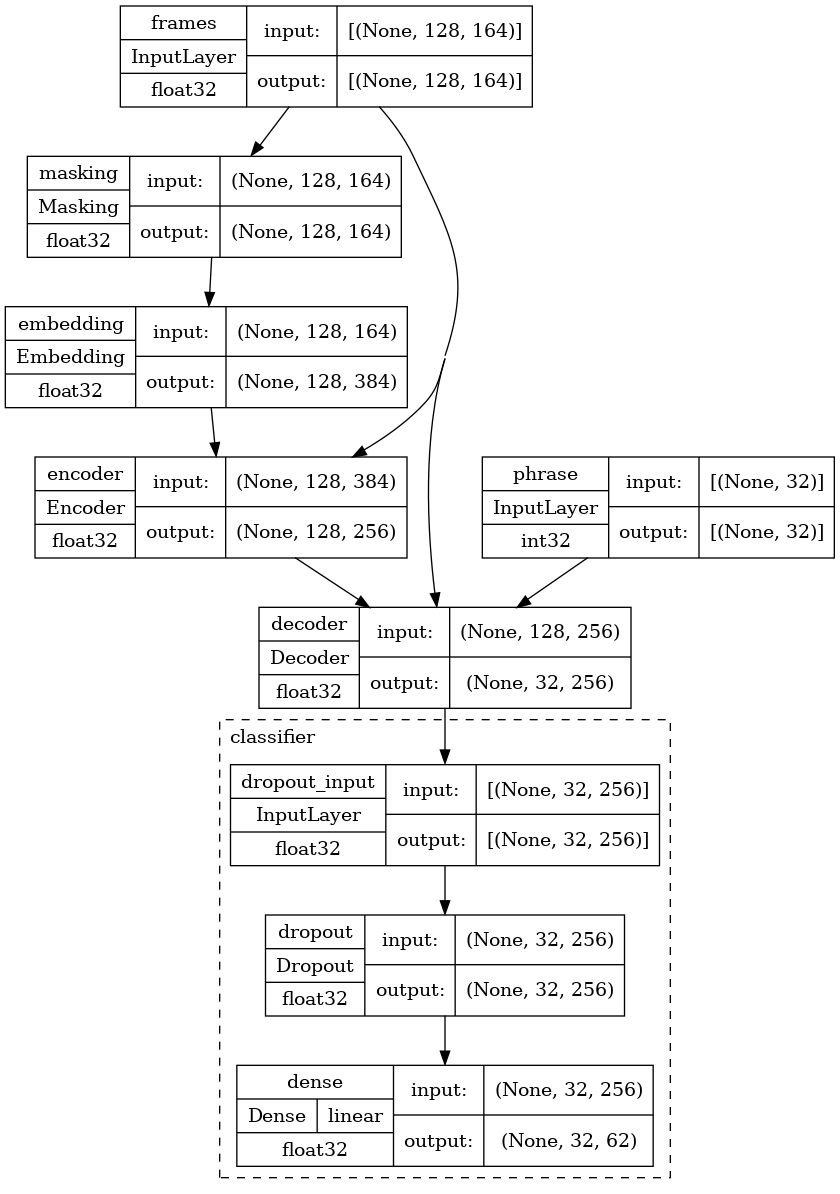

In [40]:
# Plot Model Architecture
tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True, show_layer_names=True, expand_nested=True, show_layer_activations=True)

# Verify Training Flag

In the first assert, we obtain the model's predictions using the input dataset X_batch_small with the training=False indicator. This means that we are performing static inference, where the model will not be updated or changed during this process. The predictions are stored in the variable pred.

Next, we run a for loop ten times to verify if the predictions are consistent across multiple inference runs. We do this by comparing the original predictions with new predictions obtained again using the input dataset X_batch_small and the training=False indicator. For this comparison, we use the tf.cast function to ensure that the predictions are of type int8 (8-bit integers) and then reduce the resulting tensor using tf.reduce_min.

The tf.reduce_min function is used to find the minimum value in the resulting tensor, which should be equal to 1. This indicates that all the original predictions and new predictions should be identical, indicating that the model produces consistent static results during inference.

In the second assert, we again obtain the predictions using the input dataset X_batch_small, but this time with the training=True indicator. This simulates the training process, where the model utilizes dropout technique to reduce overfitting and improve generalization. Dropout involves randomly deactivating some neurons during training to prevent the model from becoming too reliant on specific features of the training data.

Then, we run a for loop ten times to verify if the predictions significantly vary across multiple runs during training. For this, we compare the tensor of original predictions (calculated in step 1) with new predictions obtained with the X_batch_small dataset and the training=True indicator. We use the tf.cast function to ensure that the predictions are of type float32 (floating-point numbers) and then calculate the mean using tf.reduce_mean.

We expect the resulting mean value to be greater than 0.99, indicating that at least 99% of the predictions in each run during training are different from each other due to the applied dropout. This indicates that the model is using different subsets of neurons in different runs, which is desirable for improving generalization and reducing overfitting.

In [41]:
def verify_correct_training_flag():
    # Verify static output for inference
    pred = model(X_batch_small, training=False)
    for _ in tqdm(range(10)):
        assert tf.reduce_min(tf.cast(pred == model(X_batch_small, training=False), tf.int8)) == 1

    # Verify at least 99% varying output due to dropout during training
    for _ in tqdm(range(10)):
        assert tf.reduce_mean(tf.cast(pred != model(X_batch_small, training=True), tf.float32)) > 0.99
        
verify_correct_training_flag()

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

# Verify No NaN Predictions

Next, we check if there are any NaN values in the predictions made by the model.

The code starts by using the "predict" method of the model to obtain predictions for the training dataset ("train_dataset"), as no validation dataset is used in this context. The number of steps to be performed is specified using the steps parameter, which is set to N_VAL_STEPS_PER_EPOCH if the validation dataset is used, or 100 if no validation dataset is used (we are using 100). The "verbose" parameter is set to 1.

Once the predictions are obtained, the code counts how many NaN values are present in the results using the function np.isnan(y_pred).sum(). If the result of this count is greater than zero, it indicates that there are NaN values in the predictions.

Next, the code displays a histogram of the predictions to visualize the distribution of logits. In this context, logits refer to the output values of a neural network before applying an activation function, such as the softmax function. Logits represent the scores or scores associated with each class in a classification problem.

For example, let's assume you have a classification problem with three classes: "dog," "cat," and "bird." After training a neural network, it will produce a set of numerical values as output for a given input, which will correspond to the logits for each class. For instance, you could obtain [2.5, 1.8, 0.1] as logits for a given image. These values represent the scores or confidence levels that the network assigns to each class. In this case, the network is more confident that the image is a "dog" because the highest value is 2.5, followed by "cat" with 1.8, and "bird" with 0.1.

After obtaining the logits, we typically apply an activation function, such as the softmax function, to convert these values into probabilities, so they sum up to 1 and can be interpreted as the probabilities of the input belonging to each class. In this example, after applying the softmax function, we could obtain [0.64, 0.29, 0.07], indicating that the network has a 64% probability of the image being a "dog," 29% of being a "cat," and 7% of being a "bird."

This visualization is helpful to understand the distribution of predictions and to detect any extreme high or low values that could indicate a problem. Please note that the translation is based on the provided explanation and may require adjustments or additional context depending on the overall context of your work.

100/100 - 6s - 6s/epoch - 60ms/step
# NaN Values In Predictions: 0


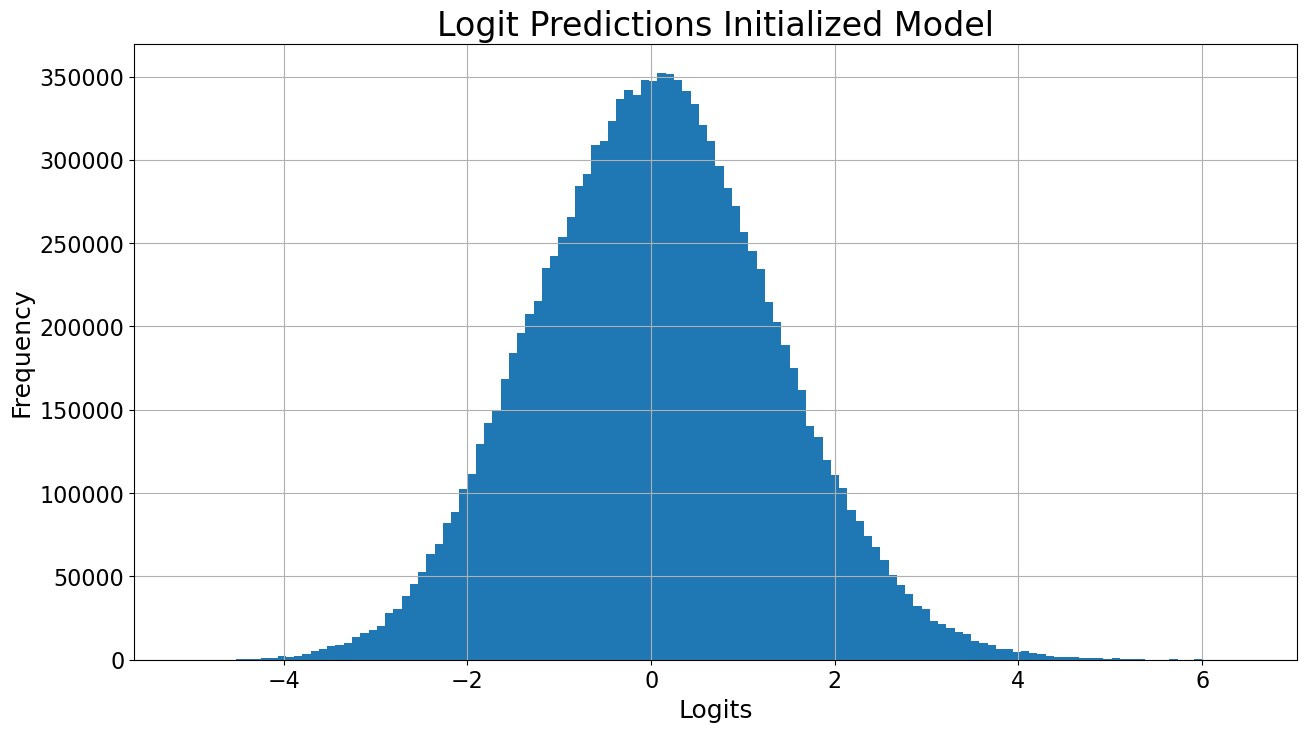

In [42]:
# Verify No NaN predictions
def verify_no_nan_predictions():
    y_pred = model.predict(
        val_dataset if USE_VAL else train_dataset,
        steps=N_VAL_STEPS_PER_EPOCH if USE_VAL else 100,
        verbose=VERBOSE,
    )

    print(f'# NaN Values In Predictions: {np.isnan(y_pred).sum()}')
    
    plt.figure(figsize=(15,8))
    plt.title(f'Logit Predictions Initialized Model')
    pd.Series(y_pred.flatten()).plot(kind='hist', bins=128)
    plt.xlabel('Logits')
    plt.grid()
    plt.show()
    
verify_no_nan_predictions()

# Learning Rate Scheduler

The lrfn function takes several arguments:

current_step: The current training step, indicating how many steps have been completed so far in the model training.

num_warmup_steps: The number of training steps used for warm-up of the learning rate. During warm-up, the learning rate gradually increases from a very small value to its maximum value.

lr_max: The maximum value that the learning rate can reach during training. After warm-up, the learning rate will oscillate between 0 and this maximum value.

num_cycles: The number of complete cycles of learning rate oscillation. A complete cycle means that the learning rate goes from its maximum value to 0 and then back to its maximum value. A value of 0.50 indicates that there will be half a complete cycle.

num_training_steps: The total number of training steps that will be performed during the entire model training.

The main purpose of the lrfn function is to calculate the learning rate for each training step. This is divided into two parts:

Learning Rate Warm-up: If the current training step is less than the number of warm-up steps (num_warmup_steps), then the learning rate will gradually increase from a very small value to its maximum value. There are two possible warm-up methods: logarithmic ('log') or exponential (2 ** -). This allows the model to adapt more smoothly to the data at the beginning of the training.

Learning Rate Oscillation: After the warm-up steps, the learning rate will oscillate between 0 and its maximum value (lr_max). The shape of this oscillation follows a modified cosine function, which goes from 0 to 1 and then back to 0 as the cycles progress.

This learning rate function allows for an effective and adaptive way to adjust the learning rate during the model training process, ensuring better convergence and optimization performance.

In [43]:
def lrfn(current_step, num_warmup_steps, lr_max, num_cycles=0.50, num_training_steps=N_EPOCHS):
    
    if current_step < num_warmup_steps:
        if WARMUP_METHOD == 'log':
            return lr_max * 0.10 ** (num_warmup_steps - current_step)
        else:
            return lr_max * 2 ** -(num_warmup_steps - current_step)
    else:
        progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))

        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress))) * lr_max

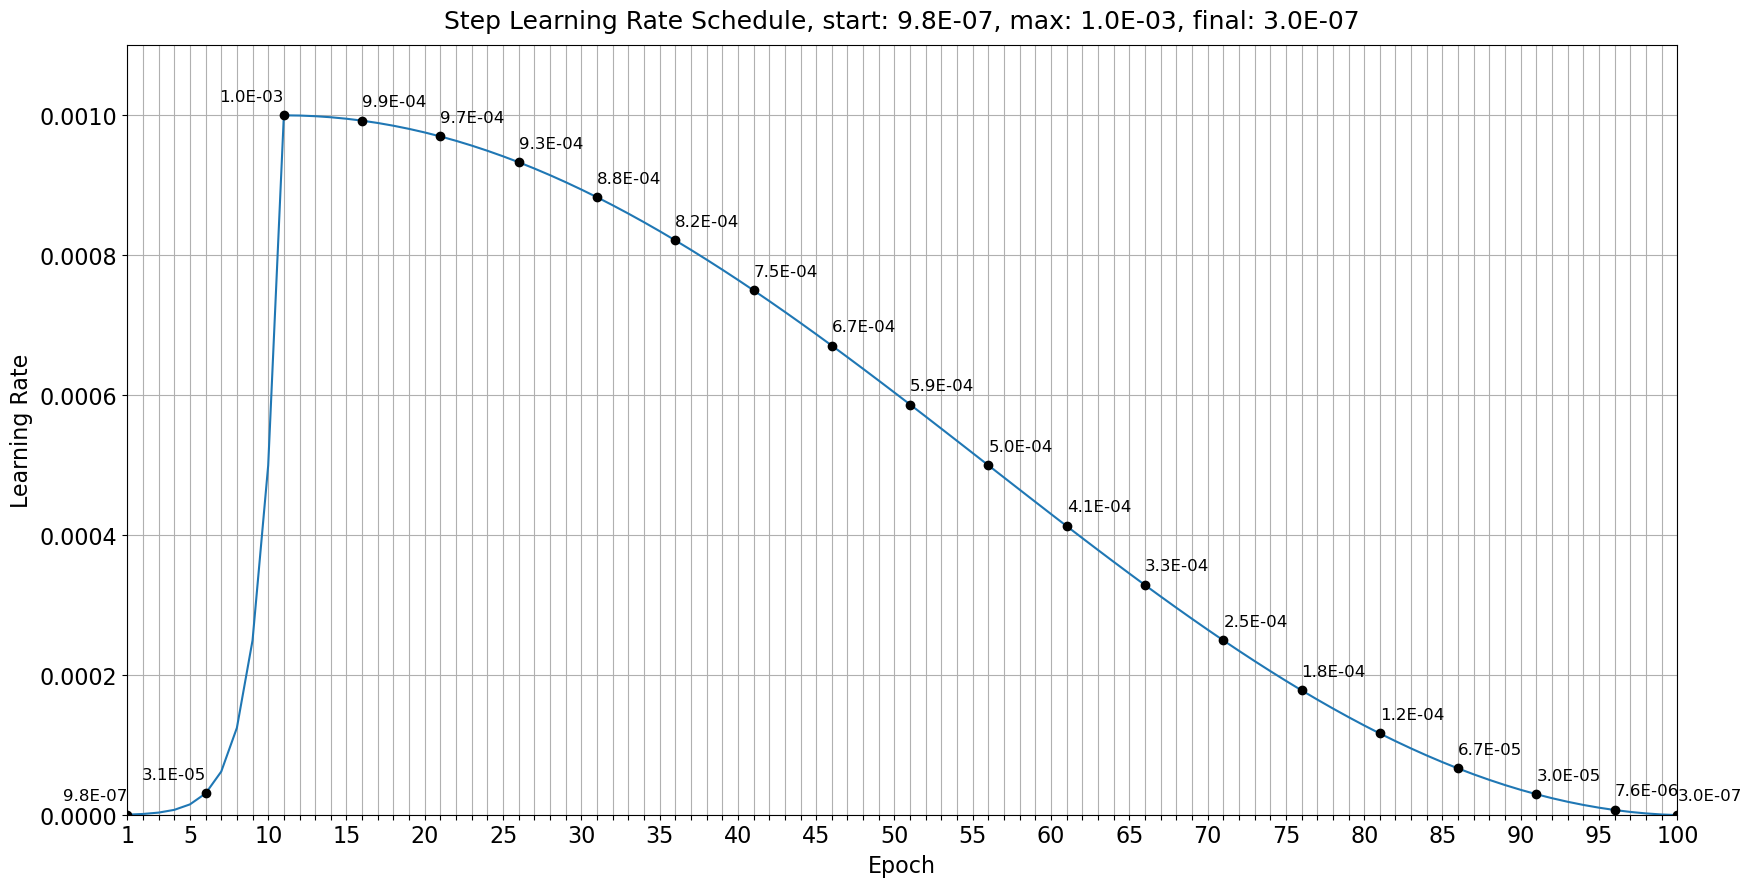

In [44]:
def plot_lr_schedule(lr_schedule, epochs):
    fig = plt.figure(figsize=(20, 10))
    plt.plot([None] + lr_schedule + [None])
    # X Labels
    x = np.arange(1, epochs + 1)
    x_axis_labels = [i if epochs <= 40 or i % 5 == 0 or i == 1 else None for i in range(1, epochs + 1)]
    plt.xlim([1, epochs])
    plt.xticks(x, x_axis_labels) # set tick step to 1 and let x axis start at 1
    
    # Increase y-limit for better readability
    plt.ylim([0, max(lr_schedule) * 1.1])
    
    # Title
    schedule_info = f'start: {lr_schedule[0]:.1E}, max: {max(lr_schedule):.1E}, final: {lr_schedule[-1]:.1E}'
    plt.title(f'Step Learning Rate Schedule, {schedule_info}', size=18, pad=12)
    
    # Plot Learning Rates
    for x, val in enumerate(lr_schedule):
        if epochs <= 40 or x % 5 == 0 or x is epochs - 1:
            if x < len(lr_schedule) - 1:
                if lr_schedule[x - 1] < val:
                    ha = 'right'
                else:
                    ha = 'left'
            elif x == 0:
                ha = 'right'
            else:
                ha = 'left'
            plt.plot(x + 1, val, 'o', color='black');
            offset_y = (max(lr_schedule) - min(lr_schedule)) * 0.02
            plt.annotate(f'{val:.1E}', xy=(x + 1, val + offset_y), size=12, ha=ha)
    
    plt.xlabel('Epoch', size=16, labelpad=5)
    plt.ylabel('Learning Rate', size=16, labelpad=5)
    plt.grid()
    plt.show()

# Learning rate for encoder
LR_SCHEDULE = [lrfn(step, num_warmup_steps=N_WARMUP_EPOCHS, lr_max=LR_MAX, num_cycles=0.50) for step in range(N_EPOCHS)]
# Plot Learning Rate Schedule
plot_lr_schedule(LR_SCHEDULE, epochs=N_EPOCHS)
# Learning Rate Callback
lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda step: LR_SCHEDULE[step], verbose=0)

Now, we define a function called plot_lr_schedule, which will be used to visualize the learning rate schedule. The function takes two arguments:

lr_schedule: A list containing the learning rate values for each training step (epoch).
epochs: The total number of training epochs.
The function performs the following steps to plot the learning rate schedule:

A line is plotted for the scheduled learning rate (lr_schedule). A None value is added at the beginning and end to prevent the line from reaching the edges of the graph.
Points are plotted on the graph for each learning rate in lr_schedule. Depending on the total number of epochs, only some points are shown to avoid the graph becoming too dense. The points are labeled with the corresponding learning rate values.
Then, a list called LR_SCHEDULE is created using the lrfn function, which calculates the learning rate for each step in the number of epochs (in this case, 20). We plot the graph to visualize the learning rate for each epoch.

Finally, a Keras callback called lr_callback is created, which will be used during the model training. This callback will automatically adjust the learning rate in each training epoch using the lambda function step: LR_SCHEDULE[step]. The learning rate value for each epoch will be obtained from the LR_SCHEDULE list that was created earlier.

# Weight Decay Callback

This code fragment defines a custom callback class called WeightDecayCallback, which will be used during the model training to update the "weight decay" term in the optimizer based on the learning rate.

Weight decay, also known as "L2 regularization," is a technique used in training machine learning models to prevent overfitting and improve model generalization.

In simple terms, weight decay involves adding a penalty term to the model's loss function that is related to the values of the model's weights. This penalty term is proportional to the square of the weight values and is added to the loss function during the optimization process.

The goal of weight decay is to penalize large model weights, meaning that the model is less likely to adjust its weights to extremely large values that could cause overfitting. By penalizing large weights, the model is encouraged to use smaller weights, which can improve generalization and prevent the model from memorizing the training data instead of learning general patterns.

The WeightDecayCallback callback has an __init__ constructor that takes an optional parameter wd_ratio, representing the weight decay ratio with respect to the learning rate (default value is equal to WD_RATIO).

The callback has an on_epoch_begin method, which is executed at the beginning of each epoch during the model training. In this method, the weight decay in the optimizer is updated by multiplying the model's current learning rate by the wd_ratio value. This allows the weight decay to automatically adjust based on the learning rate, which can help improve model regularization and prevent overfitting.

Additionally, the on_epoch_begin method prints the current values of the learning rate and weight decay to the screen, providing useful information during training to monitor how these values are changing throughout the epochs. Please note that the translation is based on the provided explanation and may require adjustments or additional context depending on the overall context of your work.

In [45]:
# Custom callback to update weight decay with learning rate
class WeightDecayCallback(tf.keras.callbacks.Callback):
    def __init__(self, wd_ratio=WD_RATIO):
        self.step_counter = 0
        self.wd_ratio = wd_ratio
    
    def on_epoch_begin(self, epoch, logs=None):
        model.optimizer.weight_decay = model.optimizer.learning_rate * self.wd_ratio
        print(f'learning rate: {model.optimizer.learning_rate.numpy():.2e}, weight decay: {model.optimizer.weight_decay.numpy():.2e}')

# Evaluate Initialized Model

In [46]:
pad_token = '^'
pad_token_idx = 59

In [47]:
# Evaluate Initialized Model On Validation Data
y_pred = model.evaluate(
    val_dataset if USE_VAL else train_dataset,
    steps=N_VAL_STEPS_PER_EPOCH if USE_VAL else TRAIN_STEPS_PER_EPOCH,
    verbose=VERBOSE,
)

969/969 - 83s - loss: 136.3367 - top1acc: 0.0203 - top5acc: 0.0828 - 83s/epoch - 85ms/step


# Baseline

This code fragment calculates the "baseline accuracy" for the model when predicting only the padding token (PAD_TOKEN).

In this particular case, the "baseline accuracy" refers to the accuracy of the model when predicting only the padding token (PAD_TOKEN) for all samples in the dataset. This accuracy is calculated as the proportion of samples in the dataset that contain only the padding token.

It is important to calculate the "baseline accuracy" to get an idea of how a simple or naive model that always predicts the most common value (the padding token) would perform. If the model we are building does not significantly surpass this baseline accuracy, it indicates that the model is not learning relevant patterns in the data and needs improvement to be useful in the task at hand.

If the variable USE_VAL is true, it means that the validation set is being used to calculate the baseline accuracy. Otherwise, the training set is used.

The baseline accuracy is calculated by comparing the actual labels (y_val or y_train) with the value of the padding token (PAD_TOKEN). The padding token is used in sequences to indicate empty or irrelevant positions.

The calculation of the baseline accuracy is done as follows:

If USE_VAL=True, the baseline accuracy is calculated using the validation set: Each element in the validation set (y_val) is compared with the padding token value (PAD_TOKEN).
A boolean array is obtained that indicates whether each element is equal to the padding token or not.
The mean of this boolean array is calculated to obtain the proportion of elements that are equal to the padding token. This proportion represents the baseline accuracy in the validation set.
If USE_VAL=False, the same process is performed but using the training set (y_train) instead.
A high baseline accuracy could indicate that the model needs improvement to be useful in the task being addressed.

In [48]:
# baseline accuracy when only pad token is predicted
if USE_VAL:
    baseline_accuracy = np.mean(y_val == PAD_TOKEN)
else:
    baseline_accuracy = np.mean(y_train == PAD_TOKEN)
print(f'Baseline Accuracy: {baseline_accuracy:.4f}')

Baseline Accuracy: 0.4100


# Train

In [49]:
gc.collect()

26333

We proceed to train the model using the train_dataset.

The steps involved in training the model are as follows:

First, we clear all previous models from the GPU to free up memory. This is done using tf.keras.backend.clear_session().

We obtain a new model using the get_model() function. We print a summary of the model using model.summary() to verify that it has been created correctly.

We start the training process of the model using the fit() method. In this method, the following arguments are provided:

x: the training data (train_dataset).
steps_per_epoch: The number of steps that will be performed in each training epoch. Each step is an update of the model's weights based on a batch of samples.
epochs: The total number of epochs that will be performed during the entire training process.
validation_data: the validation data (val_dataset). In our case, USE_VAL=False, so it is set to None.
validation_steps: The number of steps that will be performed during evaluation in each validation epoch. We do not use this parameter.
callbacks: A list of callbacks that are executed during training. In this case, we use the lr_callback to update the learning rate and the WeightDecayCallback() to update the weight decay during training.
verbose: An integer value that controls the amount of information displayed during training. A value of 0 shows nothing, a value of 1 shows a progress bar, and a value of 2 shows a progress bar and a summary of each epoch.

In [50]:
if TRAIN_MODEL:
    # Clear all models in GPU
    tf.keras.backend.clear_session()

    # Get new fresh model
    model = get_model()

    # Sanity Check
    model.summary()

    # Actual Training
    history = model.fit(
            x=train_dataset,
            steps_per_epoch=TRAIN_STEPS_PER_EPOCH,
            epochs=N_EPOCHS,
            # Only used for validation data since training data is a generator
            validation_data=val_dataset if USE_VAL else None,
            validation_steps=N_VAL_STEPS_PER_EPOCH if USE_VAL else None,
            callbacks=[
                lr_callback,
                WeightDecayCallback(),
            ],
            verbose=VERBOSE,
        )

In [51]:
# Load Weights
if LOAD_WEIGHTS:
    model.load_weights('/kaggle/input/aslfr-transformer-training-inference/model.h5')
    print(f'Successfully Loaded Pretrained Weights')

Successfully Loaded Pretrained Weights


In [52]:
# Save Model Weights
model.save_weights('model.h5')

In [53]:
# Verify Model is Loaded Correctly
model.evaluate(
    val_dataset if USE_VAL else train_dataset,
    steps=N_VAL_STEPS_PER_EPOCH if USE_VAL else TRAIN_STEPS_PER_EPOCH,
    batch_size=BATCH_SIZE,
    verbose=VERBOSE,
)

969/969 - 80s - loss: 63.4084 - top1acc: 0.8977 - top5acc: 0.9696 - 80s/epoch - 82ms/step


[63.40839767456055, 0.8977060317993164, 0.9695924520492554]

Now, we evaluate the loaded model on the specified dataset and calculate the loss and metrics of the model on that dataset. This step helps us verify that the model is loaded correctly and ready for use. Since train_dataset is a generator object, each time we access it, we obtain a new batch of different data. Therefore, we are not evaluating with the same data that we used for training.

The evaluate() function prints three values to the screen in the form of a list:

Loss (Sparse Categorical Cross Entropy with Label Smoothing in our case): This measures how well the model's predictions fit the true labels during training. A lower loss indicates a better fit of the model to the training data.

Top-1 Accuracy (TopKAccuracy(1)): This is the top-1 accuracy, also known as the accuracy in the ranking of the highest probability. It represents the fraction of samples in which the model correctly predicts the true class as the class with the highest probability. In other words, it is the accuracy for the case where only the most probable class is taken as the prediction.

Top-5 Accuracy (TopKAccuracy(5)): This is the top-5 accuracy, which represents the fraction of samples in which the model correctly predicts the true class as one of the five classes with the highest probabilities. In other words, it considers the top five most probable classes and checks if the true class is present in those five classes.

# Levenshtein Distance

We define a function called outputs2phrase, which is used to convert the model outputs (outputs) into a sequence of text (phrase). The function takes the model outputs as input, which can be a two-dimensional tensor or a one-dimensional tensor. The function performs the following steps:

If the outputs have two dimensions, it takes the index of the class with the highest probability for each sample using np.argmax(outputs, axis=1). This assumes that the outputs are class probabilities, and the model has predicted the class with the highest probability for each sample.

Then, the function iterates over the indices of the predicted classes and uses a dictionary called ORD2CHAR to convert the indices into characters. ORD2CHAR is a dictionary that maps class indices to the corresponding characters in the text sequence. For example, index 0 could be mapped to the character "a", index 1 to the character "b", and so on.

Finally, the function concatenates all the characters to form the complete text sequence and returns it as the output.

In summary, this function is useful for converting the model outputs, which are class indices or probabilities, into a readable text sequence to interpret the model predictions in text form.

In [54]:
# Output Predictions to string
def outputs2phrase(outputs):
    if outputs.ndim == 2:
        outputs = np.argmax(outputs, axis=1)
    
    return ''.join([ORD2CHAR.get(s, '') for s in outputs])

We define a function called predict_phrase that is used to generate text predictions based on an input sequence of frames using a pre-trained language model.

The steps involved in the predict_phrase function are as follows:

The function is decorated with @tf.function() to convert it into a TensorFlow graph and gain performance benefits during execution.

The function takes the frames tensor as input, which represents the input sequence of frames (similar to what we've seen previously as X_batch['frames']).

A batch dimension is added to the frames tensor using tf.expand_dims(). This is necessary because the model expects input with a batch dimension, even if we are making a prediction for a single example.

A variable called phrase is initialized with shape [1, MAX_PHRASE_LENGTH] and filled with the padding token (PAD_TOKEN). This variable is used to store the generated text sequence.

A loop is initiated that will run MAX_PHRASE_LENGTH times, which is the maximum number of tokens in the generated text sequence.

Inside the loop, the following steps are performed:

The phrase tensor is converted to int8 data type.
The model is called with inputs X = frames and y = phrase using the model() method to get the model predictions for the next token in the text sequence. These predictions are stored in the variable outputs.
phrase = tf.cast(phrase, tf.int32): The phrase tensor is converted to data type int32. This is necessary to ensure that we can use the tf.where() function correctly as it requires the arguments to have the same data type.
tf.range(MAX_PHRASE_LENGTH) < idx + 1: A boolean tensor of shape [MAX_PHRASE_LENGTH]=32 is created, where each element is True if its index is less than idx + 1, and False otherwise. This creates a mask that indicates which positions in the text sequence have not been predicted yet.
tf.argmax(outputs, axis=2, output_type=tf.int32): The tf.argmax() function is used to find the index of the token with the highest probability in the predictions (outputs). The argument axis=2 indicates that the maximum search will be done along the third axis of outputs, which corresponds to the different classes or tokens possible in the text sequence. The argument output_type=tf.int32 ensures that the result of tf.argmax() will be of integer data type int32.
tf.where(condition, x, y): This function performs a "conditional selection" operation. It takes three arguments: condition, x, and y. If condition is True at a position, the value of x at that position is selected; otherwise, the value of y is selected. In this case, condition is the mask created in step 2, x is the result of tf.argmax() in step 3 (i.e., the index of the predicted token), and y is the current text sequence (phrase). This means that if a position in the mask is True, the predicted token at that position is selected; otherwise, the current token is retained at that position.

At the end of this operation, the phrase variable has been updated with the predicted token at the corresponding position, allowing the loop to iterate and add the next token to the next position in the text sequence. This way, the text sequence is gradually constructed step by step until it is completed with MAX_PHRASE_LENGTH tokens, and the generated text sequence is obtained from the language model.

Once the loop is finished, the phrase tensor is squeezed to remove the previously added batch dimension, as we are only generating a text sequence for a single example.

The numeric values in phrase are converted into a "one-hot" representation using tf.one_hot(). This "one-hot" representation is useful for obtaining the discrete labels (tokens) in numerical format.

Finally, the function returns a dictionary with the key "outputs" and the resulting output tensor. This tensor contains the generated text sequence in "one-hot" format with shape [MAX_PHRASE_LENGTH, N_UNIQUE_CHARACTERS].

In summary, the predict_phrase function takes an input sequence of frames and uses the language model to predict the next word in the generated text sequence. It then iterates to predict all the words in the sequence. The function returns the generated text sequence in "one-hot" format to represent the tokens numerically.

Please note that the specific details and the mappings for tokens in the ORD2CHAR dictionary will depend on your specific use case and the data you are working with.

In [55]:
@tf.function(jit_compile=True)
def predict_phrase(frames):
    # Add Batch Dimension
    frames = tf.expand_dims(frames, axis=0)
    # Start Phrase
    phrase = tf.fill([1,MAX_PHRASE_LENGTH], PAD_TOKEN)

    for idx in tf.range(MAX_PHRASE_LENGTH):
        # Cast phrase to int8
        phrase = tf.cast(phrase, tf.int8)
        # Predict Next Token
        outputs = model({
            'frames': frames,
            'phrase': phrase,
        })

        # Add predicted token to input phrase
        phrase = tf.cast(phrase, tf.int32)
        phrase = tf.where(
            tf.range(MAX_PHRASE_LENGTH) < idx + 1,
            tf.argmax(outputs, axis=2, output_type=tf.int32),
            phrase,
        )

    # Squeeze outputs
    outputs = tf.squeeze(phrase, axis=0)
    outputs = tf.one_hot(outputs, N_UNIQUE_CHARACTERS)

    # Return a dictionary with the output tensor
    return outputs

    # Return a dictionary with the output tensor
    return outputs

# Levenstein Distance Train

We define a function called get_ld_train that is used to calculate the Levenshtein distance between the real phrases and the phrases predicted by the model on the training set.

The function takes as input the training data X_train and the real labels y_train, which contain sequences of frames and phrases represented by integer indices, respectively.

We create an empty list called LD_TRAIN that will be used to store the Levenshtein distances for each pair of real and predicted phrases.

Then, the function iterates through the training data using a for loop. For each pair of frames and phrase, it does the following:

It uses the predict_phrase function to predict the phrase from the input frames. The predict_phrase function takes the frames as input and returns the predicted sequence of characters in "one-hot" format. It then uses the outputs2phrase function to convert the predicted sequence of characters into a readable string.

It converts the real phrase from integer indices to a readable string using the outputs2phrase function.

It calculates the Levenshtein distance between the real phrase and the predicted phrase using the levenshtein function. The Levenshtein distance is a measure of the difference between two strings, which is calculated by counting the minimum number of operations (insertions, deletions, or substitutions of characters) required to transform one string into the other.

It appends the real phrase, the predicted phrase, and the Levenshtein distance to the LD_TRAIN list.

After completing the loop, the function converts the LD_TRAIN list into a pandas DataFrame named LD_TRAIN_DF and returns it as the result.

In [56]:
# Compute Levenstein Distances
def get_ld_train():
    N = 100 if IS_INTERACTIVE else 1000
    LD_TRAIN = []
    for idx, (frames, phrase_true) in enumerate(zip(tqdm(X_train, total=N), y_train)):
        # Predict Phrase and Convert to String
        phrase_pred = predict_phrase(frames).numpy()
        phrase_pred = outputs2phrase(phrase_pred)
        # True Phrase Ordinal to String
        phrase_true = outputs2phrase(phrase_true)
        # Add Levenstein Distance
        LD_TRAIN.append({
            'phrase_true': phrase_true,
            'phrase_true_len': len(phrase_true),
            'phrase_pred': phrase_pred,
            'levenshtein_distance': levenshtein(phrase_pred, phrase_true),
        })
        # Take subset in interactive mode
        if idx == N:
            break
            
    # Convert to DataFrame
    LD_TRAIN_DF = pd.DataFrame(LD_TRAIN)
    
    return LD_TRAIN_DF

In [57]:
LD_TRAIN_DF = get_ld_train()

# Display Errors
display(LD_TRAIN_DF.head(30))

  0%|          | 0/1000 [00:00<?, ?it/s]

,phrase_true,phrase_true_len,phrase_pred,levenshtein_distance
0,3 creekhouse,12,3 creek house,1
1,scales/kuhaylah,15,scales/kuhaylaaa,2
2,hentaihubs.com,14,hentaihubs.com,0
3,1383 william lanier,19,1383 william lanier,0
4,988 franklin lane,17,988 franklin laneet,2
5,6920 northeast 661st road,25,6920 northeast 661st road,0
6,www.freem.ne.jp,15,www.freem.me.jp,1
7,https://jsi.is/hukuoka,22,https://jsi.is/htkuokaau,3
8,239613 stolze street,20,239613 stolze street,0
9,242-197-6202,12,211-764-7602,7


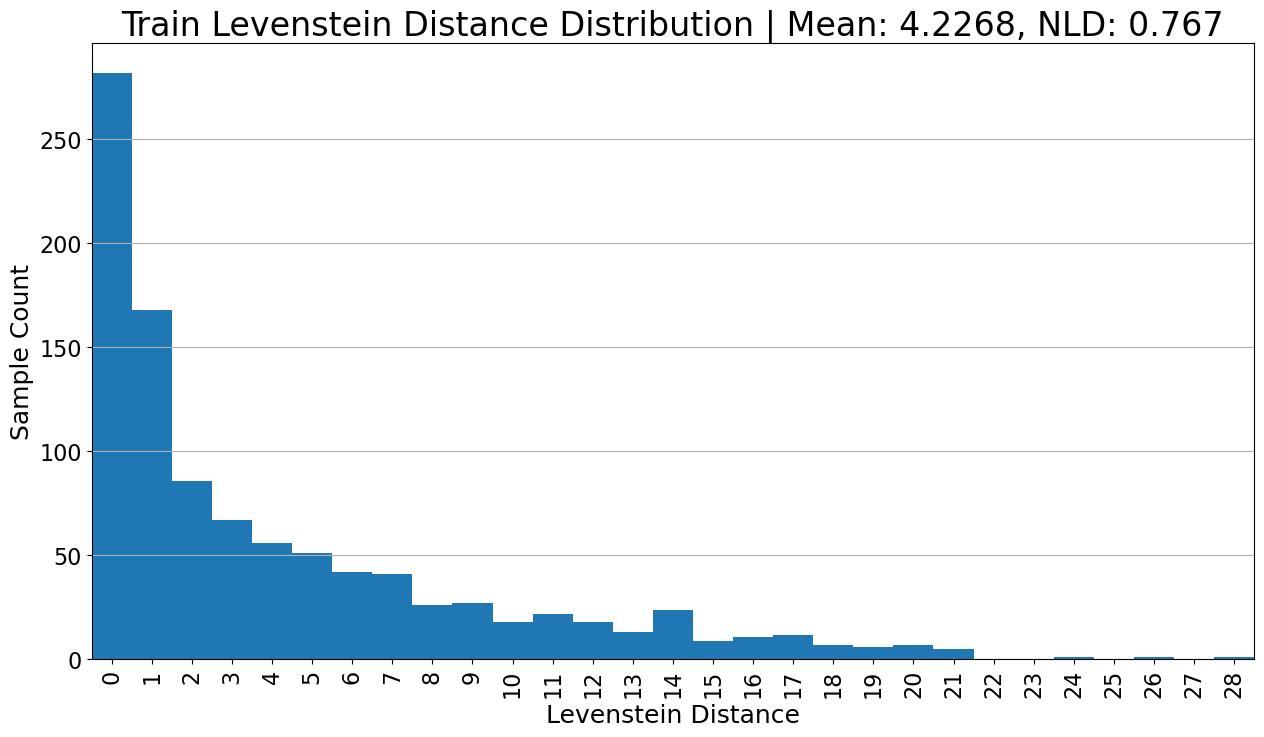

In [58]:
# Value Counts
LD_TRAIN_VC = dict([(i, 0) for i in range(LD_TRAIN_DF['levenshtein_distance'].max()+1)])
for ld in LD_TRAIN_DF['levenshtein_distance']:
    LD_TRAIN_VC[ld] += 1

# Evaluation Metric
N = LD_TRAIN_DF['phrase_true_len'].sum()
D = LD_TRAIN_DF['levenshtein_distance'].sum()
nld = (N - D) / N

LD_TRAIN_VC = dict([(i, 0) for i in range(LD_TRAIN_DF['levenshtein_distance'].max()+1)])
for ld in LD_TRAIN_DF['levenshtein_distance']:
    LD_TRAIN_VC[ld] += 1

plt.figure(figsize=(15,8))
pd.Series(LD_TRAIN_VC).plot(kind='bar', width=1)
plt.title(f'Train Levenstein Distance Distribution | Mean: {LD_TRAIN_DF.levenshtein_distance.mean():.4f}, NLD: {nld:.3f}')
plt.xlabel('Levenstein Distance')
plt.ylabel('Sample Count')
plt.xlim(-0.50, LD_TRAIN_DF.levenshtein_distance.max()+0.50)
plt.grid(axis='y')
plt.savefig('temp.png')
plt.show()

# Levenstein Distance Evaluation

In [59]:
# Compute Levenstein Distances
def get_ld_val():
    N = 100 if IS_INTERACTIVE else 1000
    LD_VAL = []
    for idx, (frames, phrase_true) in enumerate(zip(tqdm(X_val, total=N), y_val)):
        # Predict Phrase and Convert to String
        phrase_pred = predict_phrase(frames).numpy()
        phrase_pred = outputs2phrase(phrase_pred)
        # True Phrase Ordinal to String
        phrase_true = outputs2phrase(phrase_true)
        # Add Levenstein Distance
        LD_VAL.append({
            'phrase_true': phrase_true,
            'phrase_true_len': len(phrase_true),
            'phrase_pred': phrase_pred,
            'levenshtein_distance': levenshtein(phrase_pred, phrase_true),
        })
        # Take subset in interactive mode
        if idx == N:
            break
            
    # Convert to DataFrame
    LD_VAL_DF = pd.DataFrame(LD_VAL)
    
    return LD_VAL_DF

In [60]:
if USE_VAL:
    LD_VAL_DF = get_ld_val()

    # Display Errors
    display(LD_VAL_DF.head(30))

In [61]:
# Value Counts
if USE_VAL:
    # Evaluation Metric
    N = LD_VAL_DF['phrase_true_len'].sum()
    D = LD_VAL_DF['levenshtein_distance'].sum()
    nld = (N - D) / N
    
    LD_VAL_VC = dict([(i, 0) for i in range(LD_VAL_DF['levenshtein_distance'].max()+1)])
    for ld in LD_VAL_DF['levenshtein_distance']:
        LD_VAL_VC[ld] += 1

    plt.figure(figsize=(15,8))
    pd.Series(LD_VAL_VC).plot(kind='bar', width=1)
    plt.title(f'Validation Levenstein Distance Distribution | Mean: {LD_VAL_DF.levenshtein_distance.mean():.4f}, NLD: {nld:.3f}')
    plt.xlabel('Levenstein Distance')
    plt.ylabel('Sample Count')
    plt.xlim(-0.50, LD_VAL_DF.levenshtein_distance.max()+0.50)
    plt.grid(axis='y')
    plt.savefig('temp.png')
    plt.show()

# Training History

Once the model is trained and predictions are created for our data, a function called plot_history_metric is defined to plot the evolution of different metrics used in the training.

Let's go step by step to understand what each part of the code does:

if not TRAIN_MODEL: return: This line checks if the variable TRAIN_MODEL is True or False. If it is False, the function will not take any action and will stop here with return.

values = history.history[metric]: It retrieves the values of the specified metric (metric) from the training history of the model, which is stored in the history.history dictionary.

N_EPOCHS = len(values): It obtains the total number of training epochs by counting the length of the metric values.

val = 'val' in ''.join(history.history.keys()): It checks if the word 'val' is present in the keys of the model's history (if we used validation). If so, it sets val=True, otherwise, it sets it to False.

if N_EPOCHS <= 20: x = np.arange(1, N_EPOCHS + 1): If the number of epochs is less than or equal to 20, it creates an arange x with values ranging from 1 to the total number of epochs.

else: x = [1, 5] + [10 + 5 * idx for idx in range((N_EPOCHS - 10) // 5 + 1)]: If the number of epochs is greater than 20, it creates a list x with specific values spaced to clearly show the evolution of the metric in the graph.

x_ticks = np.arange(1, N_EPOCHS+1): Another arange x_ticks is created, containing values from 1 to the total number of epochs. This is used to define the x-axis labels in the graph.

If val=True:

val_values = history.history[f'val_{metric}']: It retrieves the values of the specific validation metric (val_{metric}) from the model's history.

val_argmin = f_best(val_values): It finds the index of the validation metric that has the best value, using the function f_best specified as an argument (default is np.argmax, which finds the index with the maximum value). 

plt.plot(x_ticks, val_values, label=f'val'): It plots the evolution of the validation metric on the graph with the label 'val'.
In case of val=False:

plt.plot(x_ticks, values, label=f'train'): It plots the evolution of the training metric on the graph with the label 'train'.

argmin = f_best(values): It finds the index of the training metric that has the best value, using the function f_best specified as an argument (default is np.argmax, which finds the index with the maximum value).

plt.scatter(argmin + 1, values[argmin], color='red', s=75, marker='o', label=f'train_best'): It adds a red point on the graph indicating the best training metric and its corresponding value.

If there are validation metrics (val):

plt.scatter(val_argmin + 1, val_values[val_argmin], color='purple', s=75, marker='o', label=f'val_best'): If there are validation metrics, it adds a purple point on the graph indicating the best validation metric and its corresponding value.

In [62]:
def plot_history_metric(metric, f_best=np.argmax, ylim=None, yscale=None, yticks=None):
    # Only plot when training
    if not TRAIN_MODEL:
        return
    
    plt.figure(figsize=(20, 10))
    
    values = history.history[metric]
    N_EPOCHS = len(values)
    val = 'val' in ''.join(history.history.keys())
    # Epoch Ticks
    if N_EPOCHS <= 20:
        x = np.arange(1, N_EPOCHS + 1)
    else:
        x = [1, 5] + [10 + 5 * idx for idx in range((N_EPOCHS - 10) // 5 + 1)]

    x_ticks = np.arange(1, N_EPOCHS+1)

    # Validation
    if val:
        val_values = history.history[f'val_{metric}']
        val_argmin = f_best(val_values)
        plt.plot(x_ticks, val_values, label=f'val')

    # summarize history for accuracy
    plt.plot(x_ticks, values, label=f'train')
    argmin = f_best(values)
    plt.scatter(argmin + 1, values[argmin], color='red', s=75, marker='o', label=f'train_best')
    if val:
        plt.scatter(val_argmin + 1, val_values[val_argmin], color='purple', s=75, marker='o', label=f'val_best')

    plt.title(f'Model {metric}', fontsize=24, pad=10)
    plt.ylabel(metric, fontsize=20, labelpad=10)

    if ylim:
        plt.ylim(ylim)

    if yscale is not None:
        plt.yscale(yscale)
        
    if yticks is not None:
        plt.yticks(yticks, fontsize=16)

    plt.xlabel('epoch', fontsize=20, labelpad=10)        
    plt.tick_params(axis='x', labelsize=8)
    plt.xticks(x, fontsize=16) # set tick step to 1 and let x axis start at 1
    plt.yticks(fontsize=16)
    
    plt.legend(prop={'size': 10})
    plt.grid()
    plt.show()

In [63]:
plot_history_metric('loss', f_best=np.argmin)

In [64]:
plot_history_metric('top1acc', ylim=[0,1], yticks=np.arange(0.0, 1.1, 0.1))

In [65]:
plot_history_metric('top5acc', ylim=[0,1], yticks=np.arange(0.0, 1.1, 0.1))

# Inference

The following code defines the TFLiteModel class, which represents a TensorFlow Lite (TFLite) model constructed from the previously trained model. This is useful when deploying the model on devices with limited resources, such as mobile phones, IoT devices, or embedded systems. TFLite is an optimized version of TensorFlow designed for fast and efficient inference on devices with limited computational capabilities.

TFLiteModel(tf.Module): Defines a class named TFLiteModel that inherits from tf.Module, indicating that it is a trainable entity in TensorFlow.

def __init__(self, model): The __init__ method is the constructor of the class and is automatically executed when creating an instance of TFLiteModel. It takes the argument model, which is the previously trained model that will be used as the base for the TFLite model.

self.preprocess_layer = preprocess_layer: The self.preprocess_layer is assigned the preprocessing layer used to process the input data before passing it to the base model.

self.model = model: The self.model is assigned the previously trained model that will be used as the base for the TFLite model.

@tf.function(jit_compile=True): The following methods are decorated with @tf.function, indicating that they will be compiled by TensorFlow for faster performance.

def encoder(self, x, frames_inp): This method implements the part of the model corresponding to the encoder. Similar to when constructing the model, the encoder takes two arguments; x, which represents the input data, and frames_inp, which is the shape of the data. In this function, embedding and then encoding is performed.

def decoder(self, x, phrase_inp): This method implements the part of the model corresponding to the decoder. Similar to when constructing the model, the decoder takes two arguments; x, which represents the output of the encoder, and phrase_inp, which is the shape of the "phrase" data.

@tf.function(input_signature=[tf.TensorSpec(shape=[None, N_COLS0], dtype=tf.float32, name='inputs')]): The __call__ method is defined as a TensorFlow function that will be used for inference with the TFLite model. The shape and type of the input data are specified using tf.TensorSpec.

N_INPUT_FRAMES = tf.shape(inputs)[0]: The number of rows in the input inputs is obtained, representing the number of frames.

frames_inp = self.preprocess_layer(inputs): The input data is processed using the preprocessing layer preprocess_layer.

frames_inp = tf.expand_dims(frames_inp, axis=0): A batch dimension is added to frames_inp to match the input of the original model.

encoding = self.encoder(frames_inp, frames_inp): The encoded representation of the input data is obtained using the encoder method defined earlier.

phrase = tf.fill([1,MAX_PHRASE_LENGTH], PAD_TOKEN): Similarly to before, a tensor of shape [1, MAX_PHRASE_LENGTH] filled with the value PAD_TOKEN is created. This tensor represents the output phrase that will be constructed during inference.

for idx in tf.range(MAX_PHRASE_LENGTH): It iterates over the range of indices of the maximum length of the phrase (MAX_PHRASE_LENGTH=32).

phrase = tf.cast(phrase, tf.int8): The tensor phrase is cast to type int8.

outputs = tf.cond(stop, ...): A TensorFlow conditional (tf.cond) is used to determine if the generation of the phrase should stop. If stop=True, which means the end of sentence token (END_TOKEN) was predicted, the tensor phrase converted to one-hot encoding is returned, and the generation of the phrase stops. If stop=False, the next word of the phrase is generated using the decoder method.

phrase = tf.where(tf.range(MAX_PHRASE_LENGTH) < idx + 1, ...): The phrase tensor is updated by replacing the padding token (PAD_TOKEN) with the predicted word up to the current index (idx) in the phrase generation.

predicted_token = phrase[0,idx]: The predicted token at position idx is obtained.

if not stop: stop = predicted_token == END_TOKEN: The stop variable is updated by checking if the predicted token is equal to the end of sentence token (END_TOKEN). If so, stop is set to true, indicating that phrase generation should stop.

outputs = tf.squeeze(phrase, axis=0): The added batch dimension is removed to obtain the complete generated phrase.

outputs = tf.one_hot(outputs, N_UNIQUE_CHARACTERS): The generated phrase is converted to one-hot encoding.

Finally, the __call__ method returns a dictionary with the key 'outputs' containing the generated phrase.

After defining the TFLiteModel class, an instance of it named tflite_keras_model is created, and a demonstration of inference is performed using input data demo_raw_data. Inference is done by calling the __call__ method of tflite_keras_model, and the generated phrase, the true phrase, and the input data in tensor format are displayed.

In [66]:
# Model Layer Names
for l in model.layers:
    print(l.name)

frames
masking
embedding
encoder
phrase
decoder
classifier


In [67]:
# TFLite model for submission
class TFLiteModel(tf.Module):
    def __init__(self, model):
        super(TFLiteModel, self).__init__()

        # Load the feature generation and main models
        self.preprocess_layer = preprocess_layer
        self.model = model
    
    @tf.function(jit_compile=True)
    def encoder(self, x, frames_inp):
        x = self.model.get_layer('embedding')(x)
        x = self.model.get_layer('encoder')(x, frames_inp)
        
        return x
        
    @tf.function(jit_compile=True)
    def decoder(self, x, phrase_inp, frames_inp):
        x = self.model.get_layer('decoder')(x, phrase_inp, frames_inp)
        x = self.model.get_layer('classifier')(x)
        
        return x
    
    @tf.function(input_signature=[tf.TensorSpec(shape=[None, N_COLS0], dtype=tf.float32, name='inputs')])
    def __call__(self, inputs):
        # Number Of Input Frames
        N_INPUT_FRAMES = tf.shape(inputs)[0]
        # Preprocess Data
        frames_inp = self.preprocess_layer(inputs)        
        # Add Batch Dimension
        frames_inp = tf.expand_dims(frames_inp, axis=0)
        # Get Encoding
        encoding = self.encoder(frames_inp, frames_inp)
        # Make Prediction
        phrase = tf.fill([1,MAX_PHRASE_LENGTH], PAD_TOKEN)
        # Predict One Token At A Time
        stop = False
        for idx in tf.range(MAX_PHRASE_LENGTH):
            # Cast phrase to int8
            phrase = tf.cast(phrase, tf.int8)
            # If EOS token is predicted, stop predicting
            outputs = tf.cond(
                stop,
                lambda: tf.one_hot(tf.cast(phrase, tf.int32), N_UNIQUE_CHARACTERS),
                lambda: self.decoder(encoding, phrase, frames_inp)
            )
            # Add predicted token to input phrase
            phrase = tf.cast(phrase, tf.int32)
            # Replcae PAD token with predicted token up to idx
            phrase = tf.where(
                tf.range(MAX_PHRASE_LENGTH) < idx + 1,
                tf.argmax(outputs, axis=2, output_type=tf.int32),
                phrase,
            )
            # Predicted Token
            predicted_token = phrase[0,idx]
            # If EOS (End Of Sentence) token is predicted stop
            if not stop:
                stop = predicted_token == EOS_TOKEN
            
        # Squeeze outputs
        outputs = tf.squeeze(phrase, axis=0)
        outputs = tf.one_hot(outputs, N_UNIQUE_CHARACTERS)
            
        # Return a dictionary with the output tensor
        return {'outputs': outputs }

# Define TF Lite Model
tflite_keras_model = TFLiteModel(model)

# Sanity Check
# demo_sequence_id = 1816796431
demo_sequence_id = example_parquet_df.index.unique()[0]
demo_raw_data = example_parquet_df.loc[demo_sequence_id, COLUMNS0].values
demo_phrase_true = train_sequence_id.loc[demo_sequence_id, 'phrase']
print(f'demo_raw_data shape: {demo_raw_data.shape}, dtype: {demo_raw_data.dtype}')
demo_output = tflite_keras_model(demo_raw_data)['outputs'].numpy()
print(f'demo_output shape: {demo_output.shape}, dtype: {demo_output.dtype}')
print(f'demo_outputs phrase decoded: {outputs2phrase(demo_output)}')
print(f'phrase true: {demo_phrase_true}')

demo_raw_data shape: (123, 164), dtype: float32
demo_output shape: (32, 62), dtype: float32
demo_outputs phrase decoded: 3 creek house
phrase true: 3 creekhouse


In [68]:
# Create Model Converter
keras_model_converter = tf.lite.TFLiteConverter.from_keras_model(tflite_keras_model)
# Convert Model
tflite_model = keras_model_converter.convert()
# Write Model
with open('/kaggle/working/model.tflite', 'wb') as f:
    f.write(tflite_model)

In [69]:
# Add selected_columns json to only select specific columns from input frames
with open('inference_args.json', 'w') as f:
     json.dump({ 'selected_columns': COLUMNS0.tolist() }, f)

In [70]:
# Zip Model
!zip submission.zip /kaggle/working/model.tflite /kaggle/working/inference_args.json

  adding: kaggle/working/model.tflite (deflated 9%)
  adding: kaggle/working/inference_args.json (deflated 83%)
